In [1]:
# set cell display width
from IPython.display import display, HTML
display(HTML('<style>.container { width: 930px !important; }</style>'))

In [2]:
# import ML tools
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

In [3]:
# import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize
# set grid size and style
figsize(12, 4)
sns.set_style('whitegrid')

Use "mp.colors(<index>)" as color attribute for Seaborn plots.
This is your color palette...


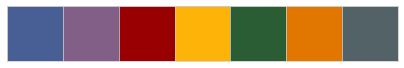

In [4]:
# import custom palette
import my_palette as mp

In [5]:
# read in actor dataset
df = pd.read_json('capstone1_ds.json')

> **GIVEN TARGET**

I will start with analyzing the unmodified dataset.

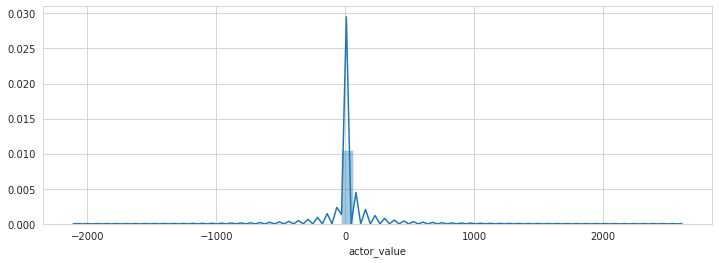

In [6]:
# plot distribution of full target
sns.distplot(df['actor_value']);

In [7]:
def plot_correlations(data):
    """Return heatmap plot of correlations"""
    fig, ax = plt.subplots(figsize=(24,24))

    sns.set(font_scale=1.4)
    sns.heatmap(
        data.corr(), vmin=0, vmax=1.0, center=0, fmt='.2f', square=True, 
        linewidths=.5, annot=True, cbar_kws={"shrink": .80});

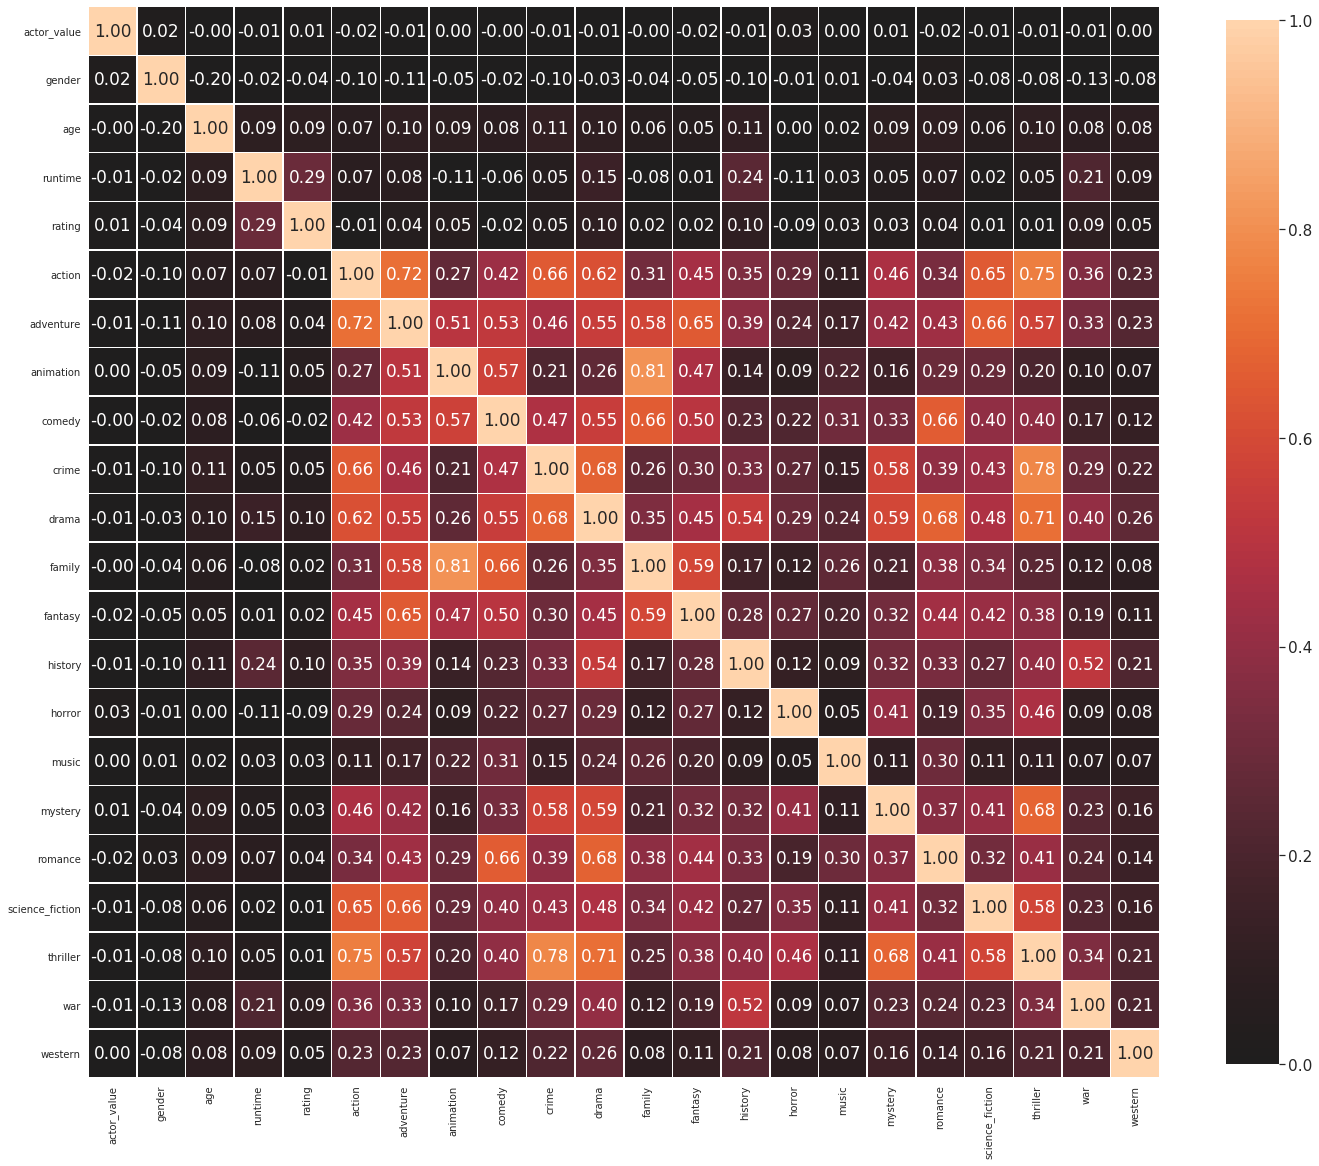

In [8]:
# plot correlations of full dataset for given target
plot_correlations(df)

The target variable has no significant correlations when the data is in this form.

In [9]:
# separate data into features and target for given target
X = df.drop('actor_value', axis=1)
y = df['actor_value']

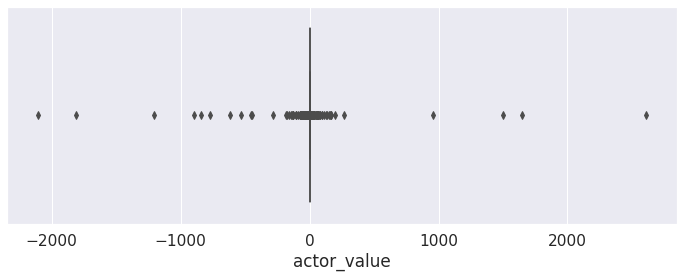

In [10]:
# plot target quartiles and outliers for given target
sns.boxplot(y);

In [11]:
# get range of given target
min(y), max(y)

(-2109.7773930898, 2612.251451965)

OLS-Given Target

I will start with a basic Ordinary Least Squares Regression to look for a signal.

In [12]:
def get_ols_model(features, target):
    """Return ordinary least squares regressor"""
    mod_ols = sm.OLS(target, features)
    results = mod_ols.fit()
    
    return results

In [13]:
# get OLS fitted regressor for given target
ols_model = get_ols_model(X, y)

In [14]:
# get results for given target
print(ols_model.summary())

                                 OLS Regression Results                                
Dep. Variable:            actor_value   R-squared (uncentered):                   0.003
Model:                            OLS   Adj. R-squared (uncentered):              0.002
Method:                 Least Squares   F-statistic:                              2.182
Date:                Wed, 24 Jun 2020   Prob (F-statistic):                     0.00137
Time:                        15:39:24   Log-Likelihood:                         -77142.
No. Observations:               14996   AIC:                                  1.543e+05
Df Residuals:                   14975   BIC:                                  1.545e+05
Df Model:                          21                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

The OLS is having no luck.<br>
The lack of correlations is to blame.

In [15]:
def get_scores(features, target, model):
    """Return root mean squared error and adjusted R2 score for regressor"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27)
    
    rmse = mean_squared_error(y_test, model.predict(X_test), squared=False)
    r2 = r2_score(y_test, model.predict(X_test))
    n = X_train.shape[0]
    p = X_train.shape[1]
    adj_r2 = 1 - (1 - r2) * ((n - 1)  / (n - p - 1))

    return f'Root MSE: {rmse:.2f}, STD Target: {np.std(target):.2f}, Adj. R2: {adj_r2:.4f}'

In [16]:
# get OLS scores for given target
get_scores(X, y, ols_model)

'Root MSE: 33.62, STD Target: 41.54, Adj. R2: -0.0044'

The RMSE is within the target standard deviation.<br>
The adjusted R Squared Score implies that OLS is a useless model with the data in this form.

RFR-Given Target

I will observe the out of the box Random Forest Regressor model.

In [17]:
def get_base_model(features, target):
    """Return base random forest regressor model"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27)
    model = RandomForestRegressor(random_state=27)
    model.fit(X_train, y_train)
    
    return model

In [18]:
def get_params(model):
    """Return hyperparameters of interest from regressor"""
    series = pd.Series(
        model.get_params(), name='full_target').drop(
        ['bootstrap', 'ccp_alpha', 'criterion', 'max_leaf_nodes', 'max_samples', 
        'min_impurity_decrease', 'min_impurity_split', 'min_weight_fraction_leaf', 
        'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])
    
    return series

In [19]:
# instanciate base model for given target and get parameters
base_model = get_base_model(X, y)
get_params(base_model)

max_depth            None
max_features         auto
min_samples_leaf        1
min_samples_split       2
n_estimators          100
Name: full_target, dtype: object

In [20]:
# get base model scores for given target
get_scores(X, y, base_model)

'Root MSE: 40.57, STD Target: 41.54, Adj. R2: -0.4620'

The RFR model is useless at this point, as well.

In [21]:
def plot_predictions(features, target, model):
    """Return plot of observed target vs. predictions"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27)

    sns.scatterplot(y_test, model.predict(X_test), color=mp.colors(1))
    
    plt.xlabel('Observed')
    plt.ylabel('Predicted')
    
    plt.title("Ground Truth vs Predicted");

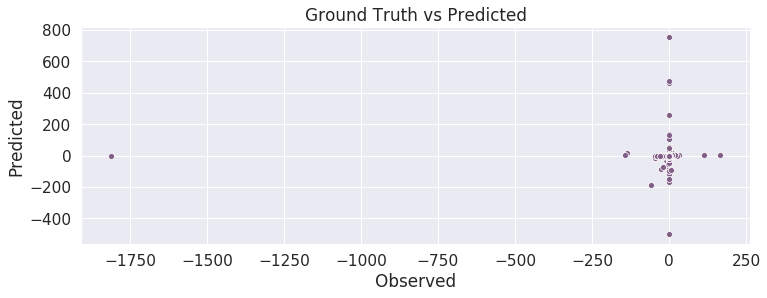

In [22]:
# plot base model observed vs. predictions using full target
plot_predictions(X, y, base_model)

In [23]:
def plot_residuals(features, target, model):
    """Return plot of residuals of observed target vs. predictions"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27)

    sns.residplot(
        y_test, model.predict(X_test), lowess=True, scatter_kws={'s':10}, 
        color=mp.colors(2), line_kws={'linewidth':3})
    
    plt.xlabel('Actor Value')
    plt.ylabel('Residuals')
    
    plt.title("Ground Truth vs Predicted");

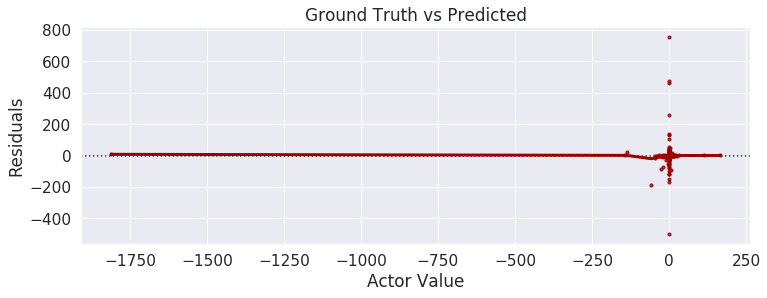

In [24]:
# plot residuals for base model using full target
plot_residuals(X, y, base_model)

In [25]:
def plot_residual_distribution(features, target, model):
    """Return plot of distribution of residuals"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27)
    
    sns.distplot(
        (y_test - model.predict(X_test)), bins=300, rug=True, axlabel='Residual', 
        color=mp.colors(4))

    plt.ylabel('Frequency')

    plt.title('Distribution of Residuals');

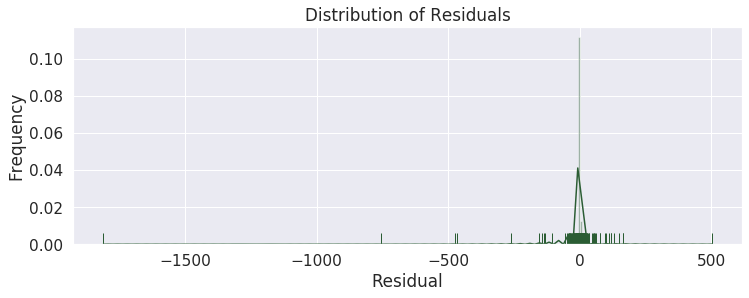

In [26]:
# plot residuals distribution for base model using full target
plot_residual_distribution(X, y, base_model)

The errors are huge.

> **NO OUTLIERS TARGET**

I will look for improvements by removing outliers using the z-score.

In [27]:
# create Z-score Series
z = (df["actor_value"] - np.mean(df["actor_value"])) / np.std(df["actor_value"])
# get number of outlier observations according to z-score
(np.absolute(z) > 3).sum()

31

In [28]:
# find percentage of outliers in datset having Z-Score > 3
(np.absolute(z) > 3).sum() / df.shape[0] * 100

0.20672179247799416

In [29]:
# drop target outliers
no_df = df.drop(
    index=df.loc[np.absolute(
        np.divide(
            np.subtract(
                df["actor_value"], np.mean(df["actor_value"])
            ), np.std(df["actor_value"]))) > 3].index)

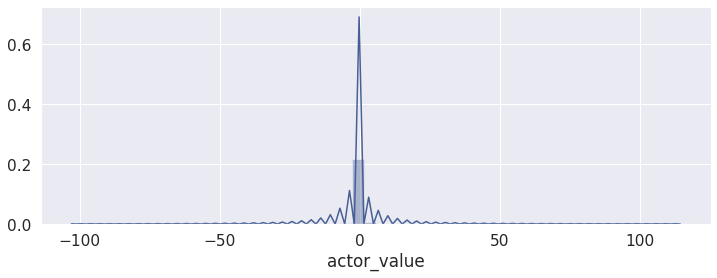

In [30]:
# plot distribution of no outliers target
sns.distplot(no_df['actor_value']);

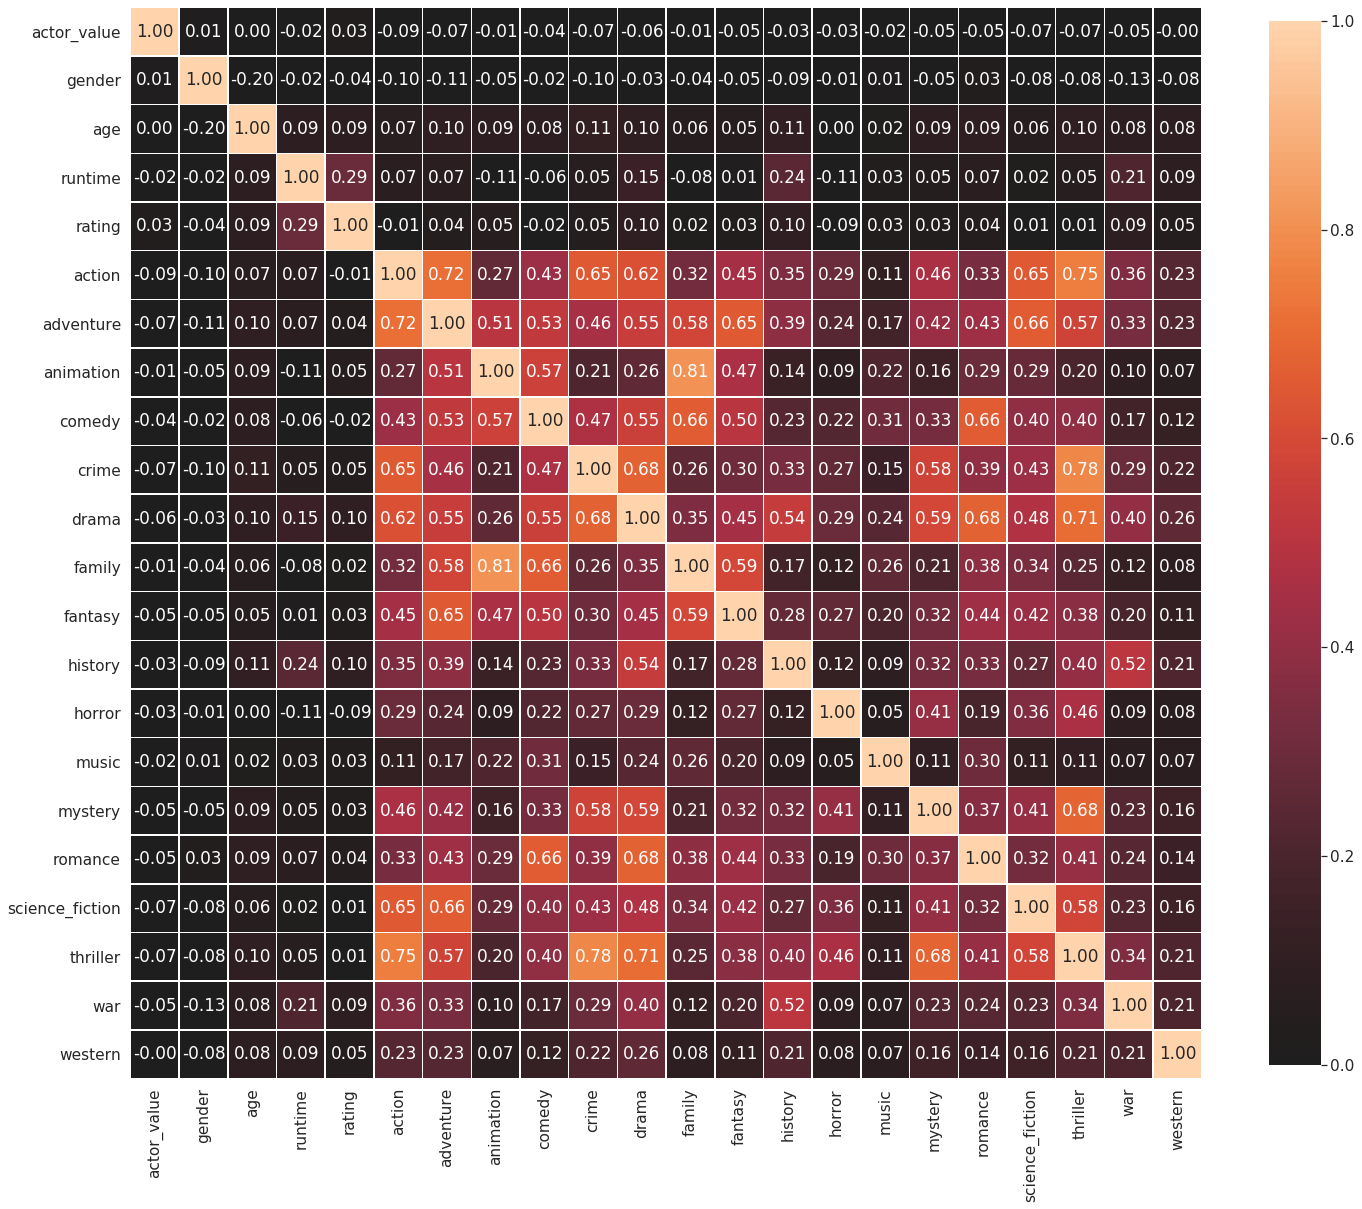

In [31]:
# plot correlations for dataset with no outliers target
plot_correlations(no_df)

A few small correlations are showing.

In [32]:
# separate data into features and target
X_no = no_df.drop('actor_value', axis=1)
y_no = no_df['actor_value']

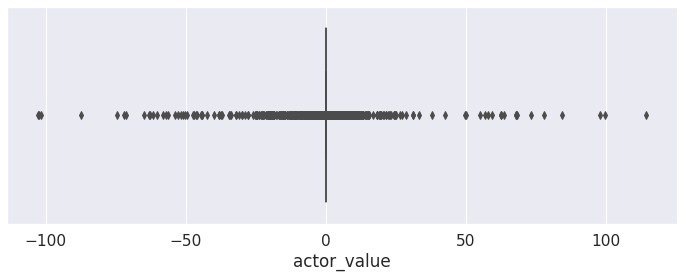

In [33]:
# plot target quartiles and new outliers
sns.boxplot(y_no);

In [34]:
# get range of no outliers target
min(y_no), max(y_no)

(-102.8912558676, 114.4299637388)

The range of the target has reduced by a factor.

OLS-No Outliers Target

In [35]:
# get OLS fitted regressor for no outliers target
ols_model_no = get_ols_model(X_no, y_no)

In [36]:
# get results for no outliers target
print(ols_model_no.summary())

                                 OLS Regression Results                                
Dep. Variable:            actor_value   R-squared (uncentered):                   0.011
Model:                            OLS   Adj. R-squared (uncentered):              0.009
Method:                 Least Squares   F-statistic:                              7.818
Date:                Wed, 24 Jun 2020   Prob (F-statistic):                    4.85e-24
Time:                        15:39:35   Log-Likelihood:                         -43582.
No. Observations:               14965   AIC:                                  8.721e+04
Df Residuals:                   14944   BIC:                                  8.737e+04
Df Model:                          21                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

Still no signal with OLS.

In [37]:
# get OLS scores for no outliers target
get_scores(X_no, y_no, ols_model_no)

'Root MSE: 3.36, STD Target: 4.48, Adj. R2: 0.0070'

RFR-No Outliers Target

In [38]:
# instanciate base model for no outliers target and get parameters
base_model_no = get_base_model(X_no, y_no)
get_params(base_model_no)

max_depth            None
max_features         auto
min_samples_leaf        1
min_samples_split       2
n_estimators          100
Name: full_target, dtype: object

In [39]:
# base model scores for no outliers target
get_scores(X_no, y_no, base_model_no)

'Root MSE: 3.63, STD Target: 4.48, Adj. R2: -0.1583'

It's the same for RFR, but the errors have significantly decreased.

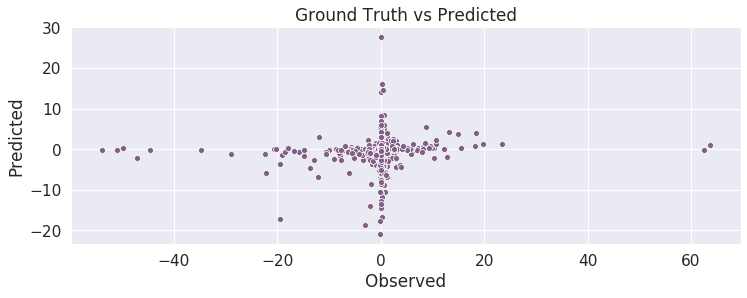

In [40]:
# plot base model observed vs. predictions using no outliers target
plot_predictions(X_no, y_no, base_model_no)

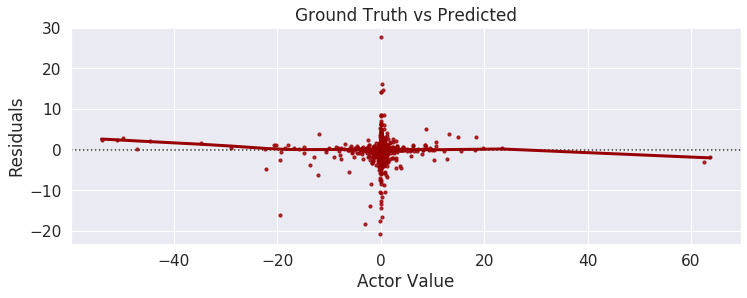

In [41]:
# plot residuals for base model using no outliers target
plot_residuals(X_no, y_no, base_model_no)

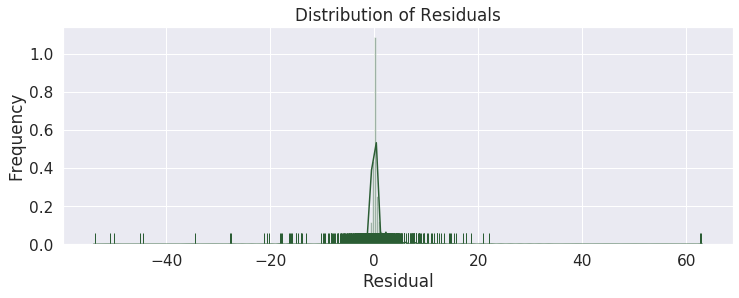

In [42]:
# plot residuals distribution for base model using no outliers target
plot_residual_distribution(X_no, y_no, base_model_no)

> **LOG POSITIVE TARGET**

Taking the natural log of the target will transform it into a workable form.<br>
When I created this dataset, I essentially used two different functions to build the dependent variable.<br>
The negative and positive values for the target were featurized separately.<br>
In order to take the log of the target variable, I must divide it into two parts at the origin.<br>
I will work on the positive values, now.

In [43]:
# keep only positive target
pos_df = df[df['actor_value'] > 0]

In [44]:
# take natural log of positive target
log_pos_df = pos_df.copy()
log_pos_df['actor_value'] = np.log(log_pos_df['actor_value'])

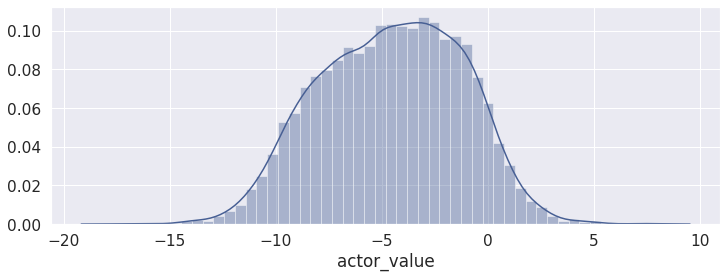

In [45]:
# plot distribution of positive log target
sns.distplot(log_pos_df['actor_value']);

Now, the distribution looks Gaussian.

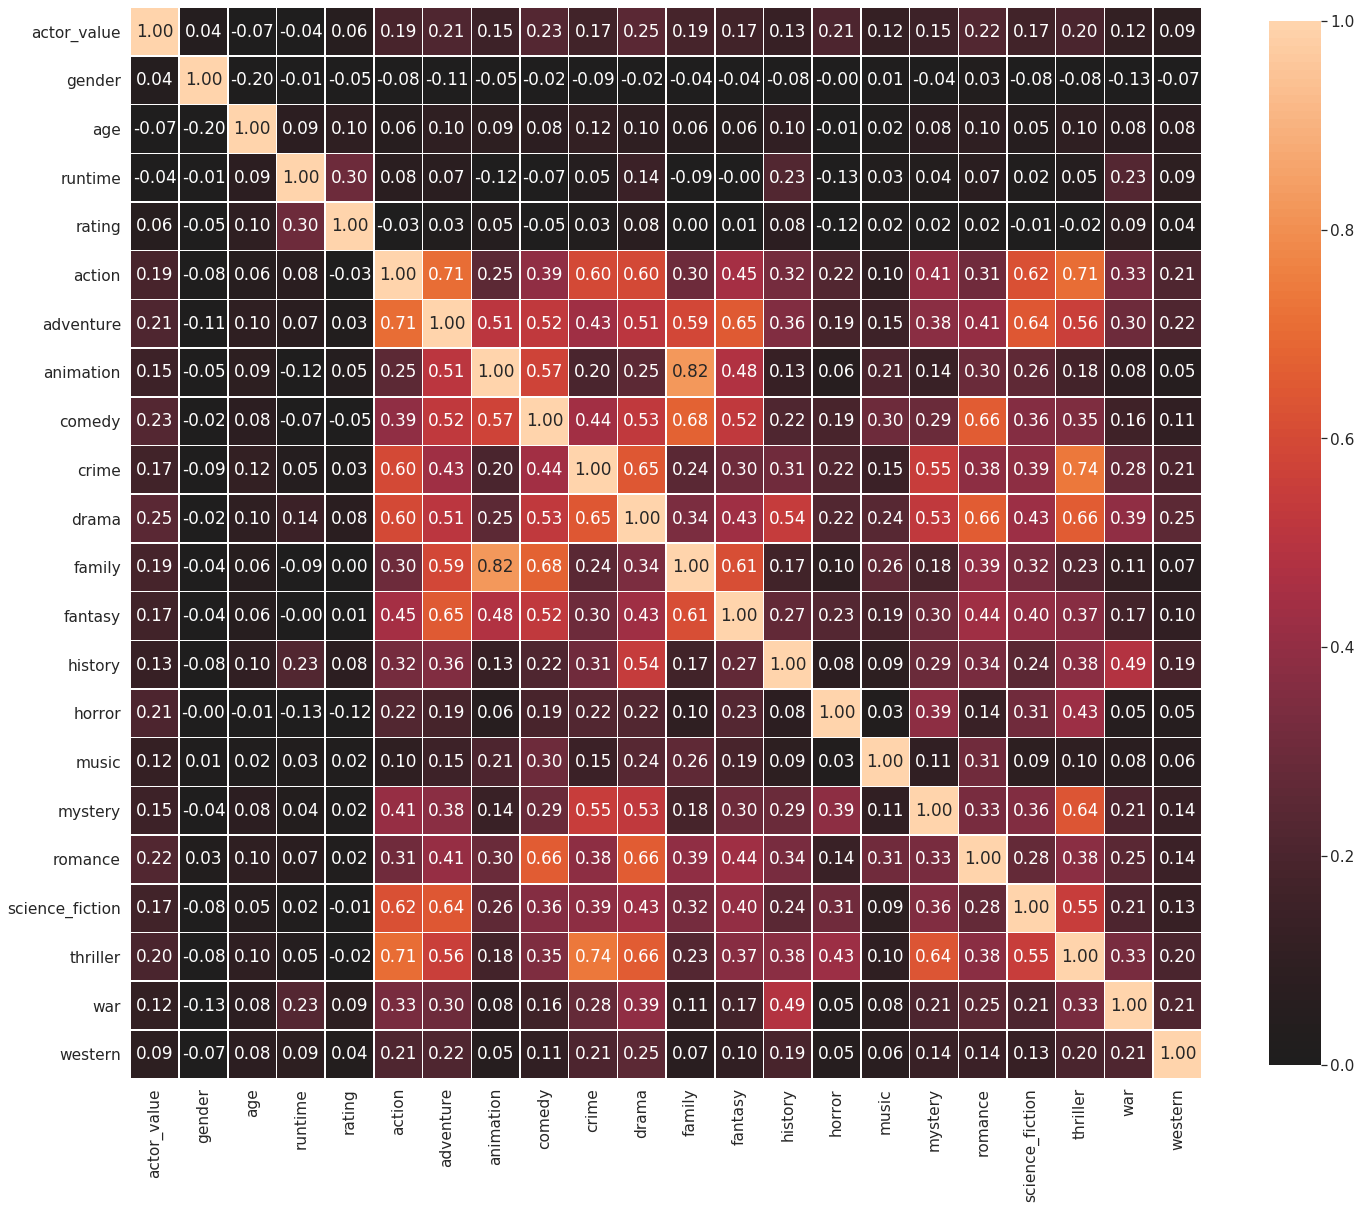

In [46]:
# plot correlations for dataset with natural log of positive value target
plot_correlations(log_pos_df)

Correlations are emerging.

In [47]:
# separate data into features and target
X_log_pos = log_pos_df.drop('actor_value', axis=1)
y_log_pos = log_pos_df['actor_value']

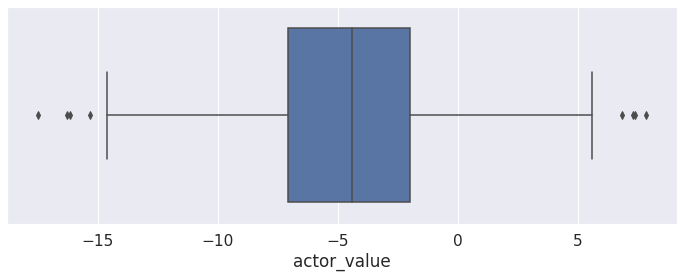

In [48]:
# plot target quartiles and outliers
sns.boxplot(y_log_pos);

In [49]:
# get range of natural log of positive target
min(y_log_pos), max(y_log_pos)

(-17.50839803347575, 7.867967753743332)

OLS-Natural Log Positive Target

In [50]:
# get OLS fitted regressor for log positive target
ols_model_log_pos = get_ols_model(X_log_pos, y_log_pos)

In [51]:
# get OLS results for log positive target
print(ols_model_log_pos.summary())

                                 OLS Regression Results                                
Dep. Variable:            actor_value   R-squared (uncentered):                   0.691
Model:                            OLS   Adj. R-squared (uncentered):              0.690
Method:                 Least Squares   F-statistic:                              1110.
Date:                Wed, 24 Jun 2020   Prob (F-statistic):                        0.00
Time:                        15:39:47   Log-Likelihood:                         -26833.
No. Observations:               10469   AIC:                                  5.371e+04
Df Residuals:                   10448   BIC:                                  5.386e+04
Df Model:                          21                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

OLS is giving significant results.

In [52]:
# get OLS scores for log positive target
get_scores(X_log_pos, y_log_pos, ols_model_log_pos)

'Root MSE: 3.20, STD Target: 3.33, Adj. R2: 0.1084'

The Adjusted R2 is for the validation data.<br>
The model is extremely overfit.

RFR-Natural Log Positive Target

In [53]:
# instanciate base model for natural log of positive target and get parameters
base_model_log_pos = get_base_model(X_log_pos, y_log_pos)
get_params(base_model_log_pos)

max_depth            None
max_features         auto
min_samples_leaf        1
min_samples_split       2
n_estimators          100
Name: full_target, dtype: object

In [54]:
# base model scores for natural log of positive target
get_scores(X_log_pos, y_log_pos, base_model_log_pos)

'Root MSE: 3.04, STD Target: 3.33, Adj. R2: 0.1970'

The evaluation scores are better than what we got using OLS.

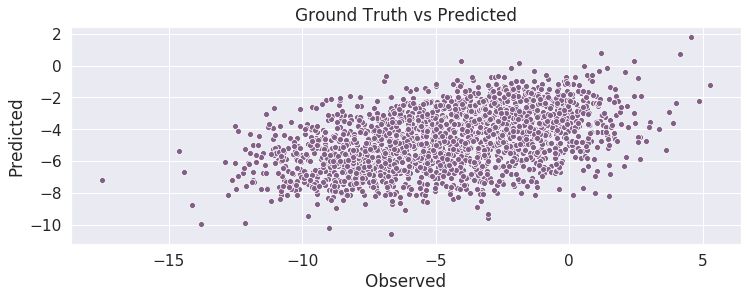

In [55]:
# plot base model observed vs. predictions using natural log of positive target
plot_predictions(X_log_pos, y_log_pos, base_model_log_pos)

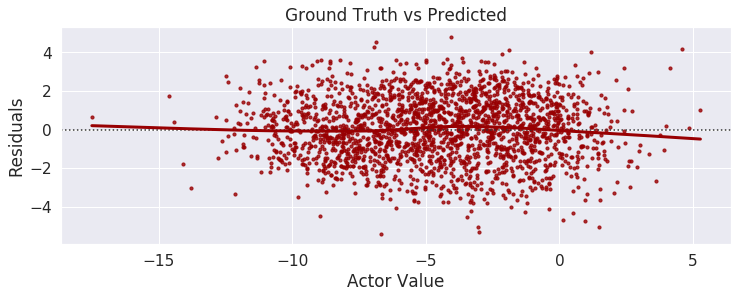

In [56]:
# plot residuals for base model using natural log of positive target
plot_residuals(X_log_pos, y_log_pos, base_model_log_pos)

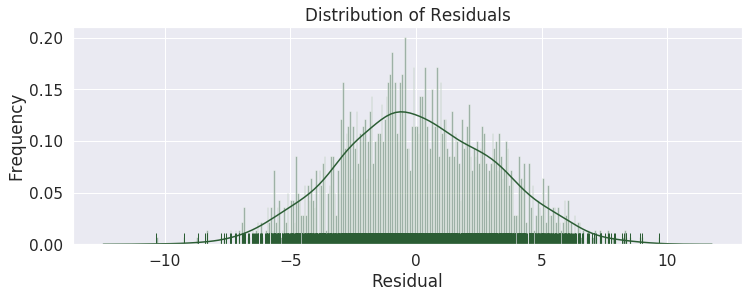

In [57]:
# plot residuals distribution for base model using natural log of positive target
plot_residual_distribution(X_log_pos, y_log_pos, base_model_log_pos)

All of the plots indicate the errors have settled down.

> **LOG NEGATIVE TARGET**

I will do the same for the negative target values.

In [58]:
# keep only negative target
neg_df = df[df['actor_value'] < 0]

In [59]:
# take log of absolute value of negative target
log_neg_df = neg_df.copy()
log_neg_df['actor_value'] = np.log(np.absolute(log_neg_df['actor_value']))

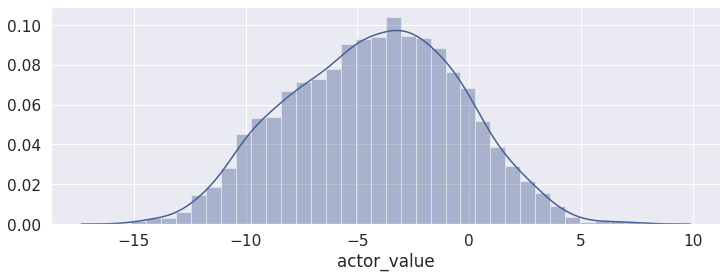

In [60]:
# plot distribution of log of negative target
sns.distplot(log_neg_df['actor_value']);

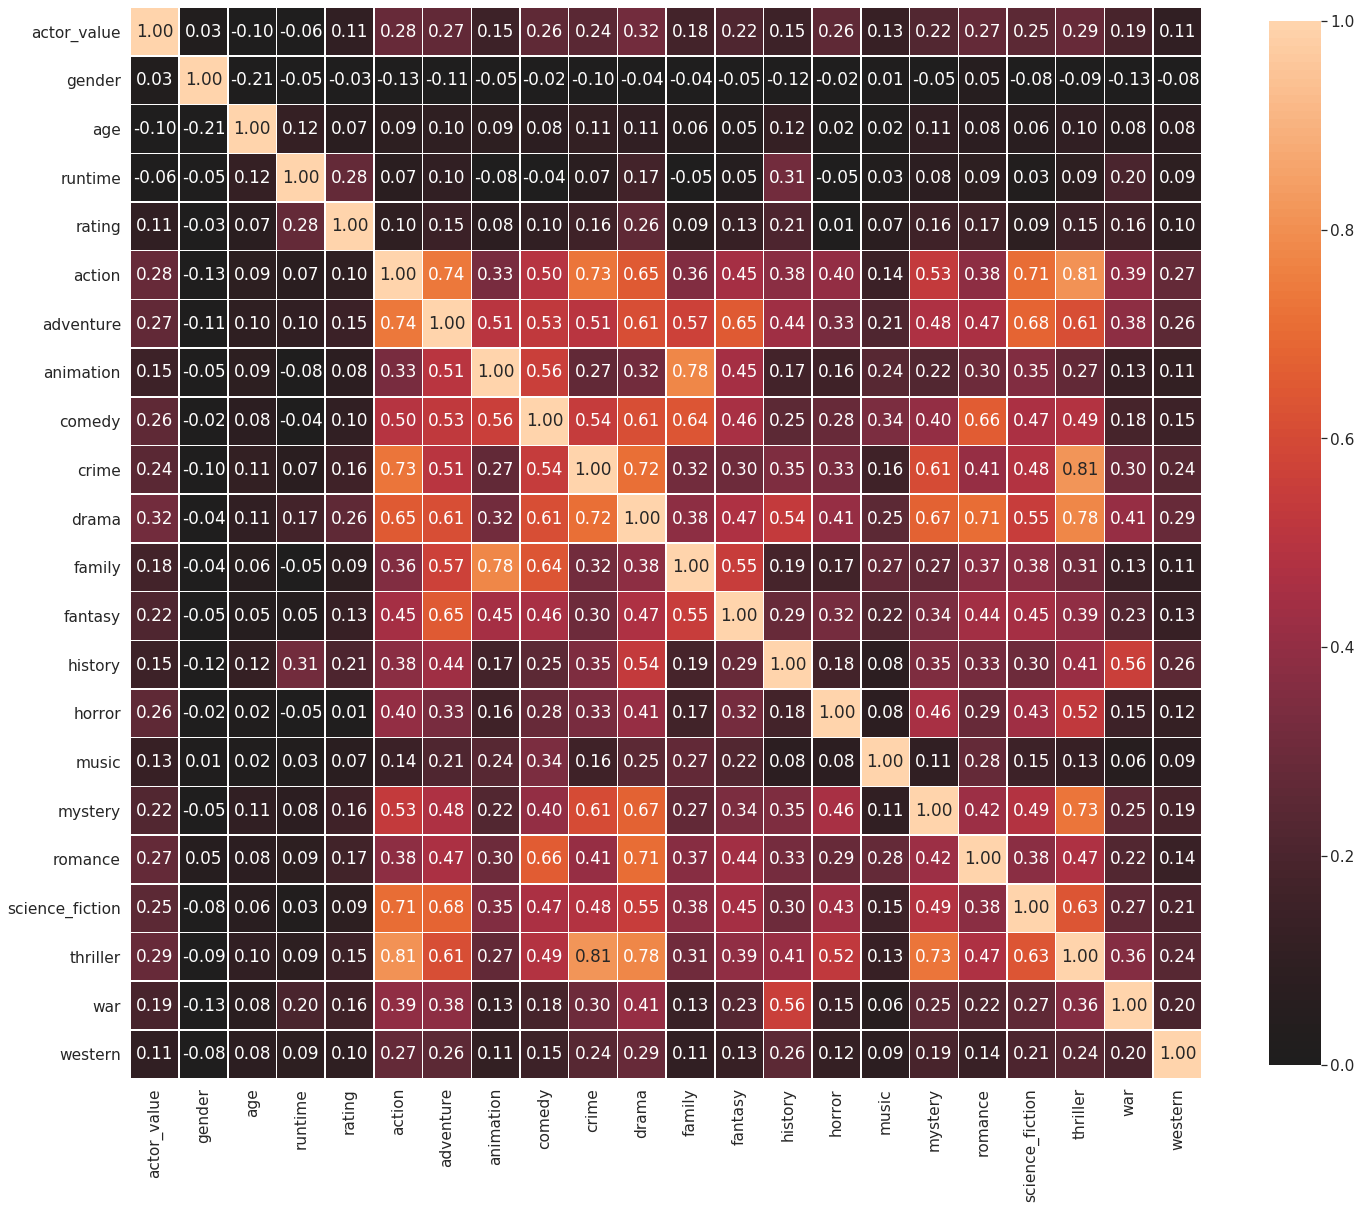

In [61]:
# plot correlations for dataset with log of negative target
plot_correlations(log_neg_df)

In [62]:
# separate data into features and target
X_log_neg = log_neg_df.drop('actor_value', axis=1)
y_log_neg = log_neg_df['actor_value']

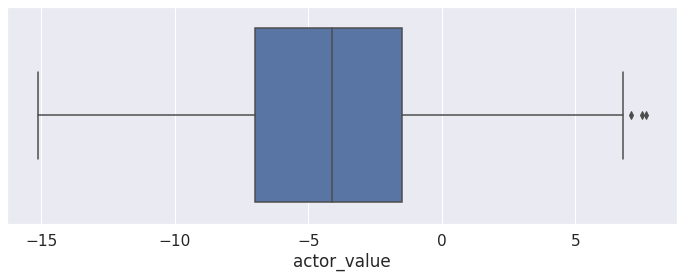

In [63]:
# plot target quartiles and outliers
sns.boxplot(y_log_neg);

In [64]:
# get range of natural log of positive target
min(y_log_neg), max(y_log_neg)

(-15.128926273671592, 7.654337719999193)

OLS-Natural Log Negative Target

In [65]:
# get OLS fitted regressor for log negative target
ols_model_log_neg = get_ols_model(X_log_neg, y_log_neg)

In [66]:
# get OLS results for log negative target
print(ols_model_log_neg.summary())

                                 OLS Regression Results                                
Dep. Variable:            actor_value   R-squared (uncentered):                   0.632
Model:                            OLS   Adj. R-squared (uncentered):              0.630
Method:                 Least Squares   F-statistic:                              362.9
Date:                Wed, 24 Jun 2020   Prob (F-statistic):                        0.00
Time:                        15:39:53   Log-Likelihood:                         -11838.
No. Observations:                4461   AIC:                                  2.372e+04
Df Residuals:                    4440   BIC:                                  2.385e+04
Df Model:                          21                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

In [67]:
# get OLS scores for log negative target
get_scores(X_log_neg, y_log_neg, ols_model_log_neg)

'Root MSE: 3.33, STD Target: 3.77, Adj. R2: 0.1805'

RFR-Natural Log Negative Target

In [68]:
# instanciate base model for natural log of negative target and get parameters
base_model_log_neg = get_base_model(X_log_neg, y_log_neg)
get_params(base_model_log_neg)

max_depth            None
max_features         auto
min_samples_leaf        1
min_samples_split       2
n_estimators          100
Name: full_target, dtype: object

In [69]:
# base model scores for natural log of negative target
get_scores(X_log_neg, y_log_neg, base_model_log_neg)

'Root MSE: 3.19, STD Target: 3.77, Adj. R2: 0.2503'

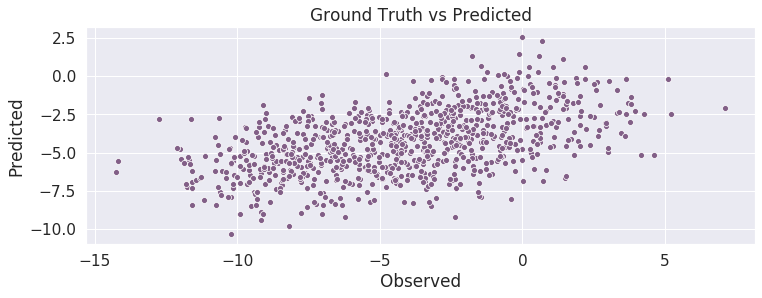

In [70]:
# plot base model observed vs. predictions using natural log of negative target
plot_predictions(X_log_neg, y_log_neg, base_model_log_neg)

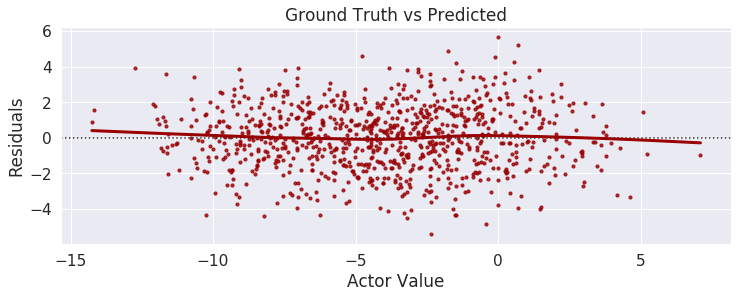

In [71]:
# plot residuals for base model using natural log of negative target
plot_residuals(X_log_neg, y_log_neg, base_model_log_neg)

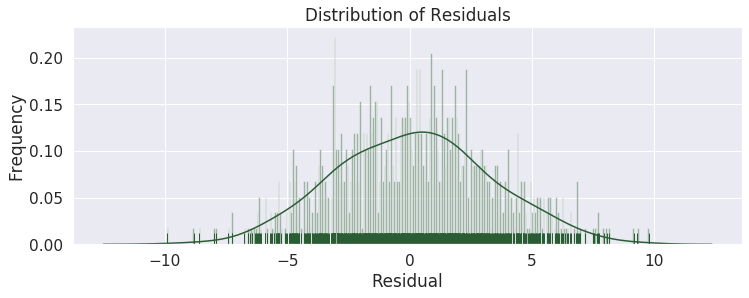

In [72]:
# plot residuals distribution for base model using natural log of negative target
plot_residual_distribution(X_log_neg, y_log_neg, base_model_log_neg)

The models fit the negative target slightly better.

> **LOG ALL TARGET**

Now, I can concatenate these observations, making a single target, again.<br>
I can get away with this, because of the way that I engineered the target variable in the first place.<br>
I built my transform functions to give all targets the same proportional representation with respect to the movie budget.

In [73]:
# bring data back together
log_all_df = pd.concat([log_pos_df, log_neg_df])

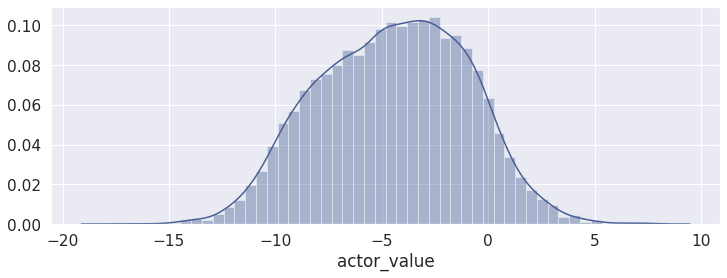

In [74]:
# plot distribution of full log target
sns.distplot(log_all_df['actor_value']);

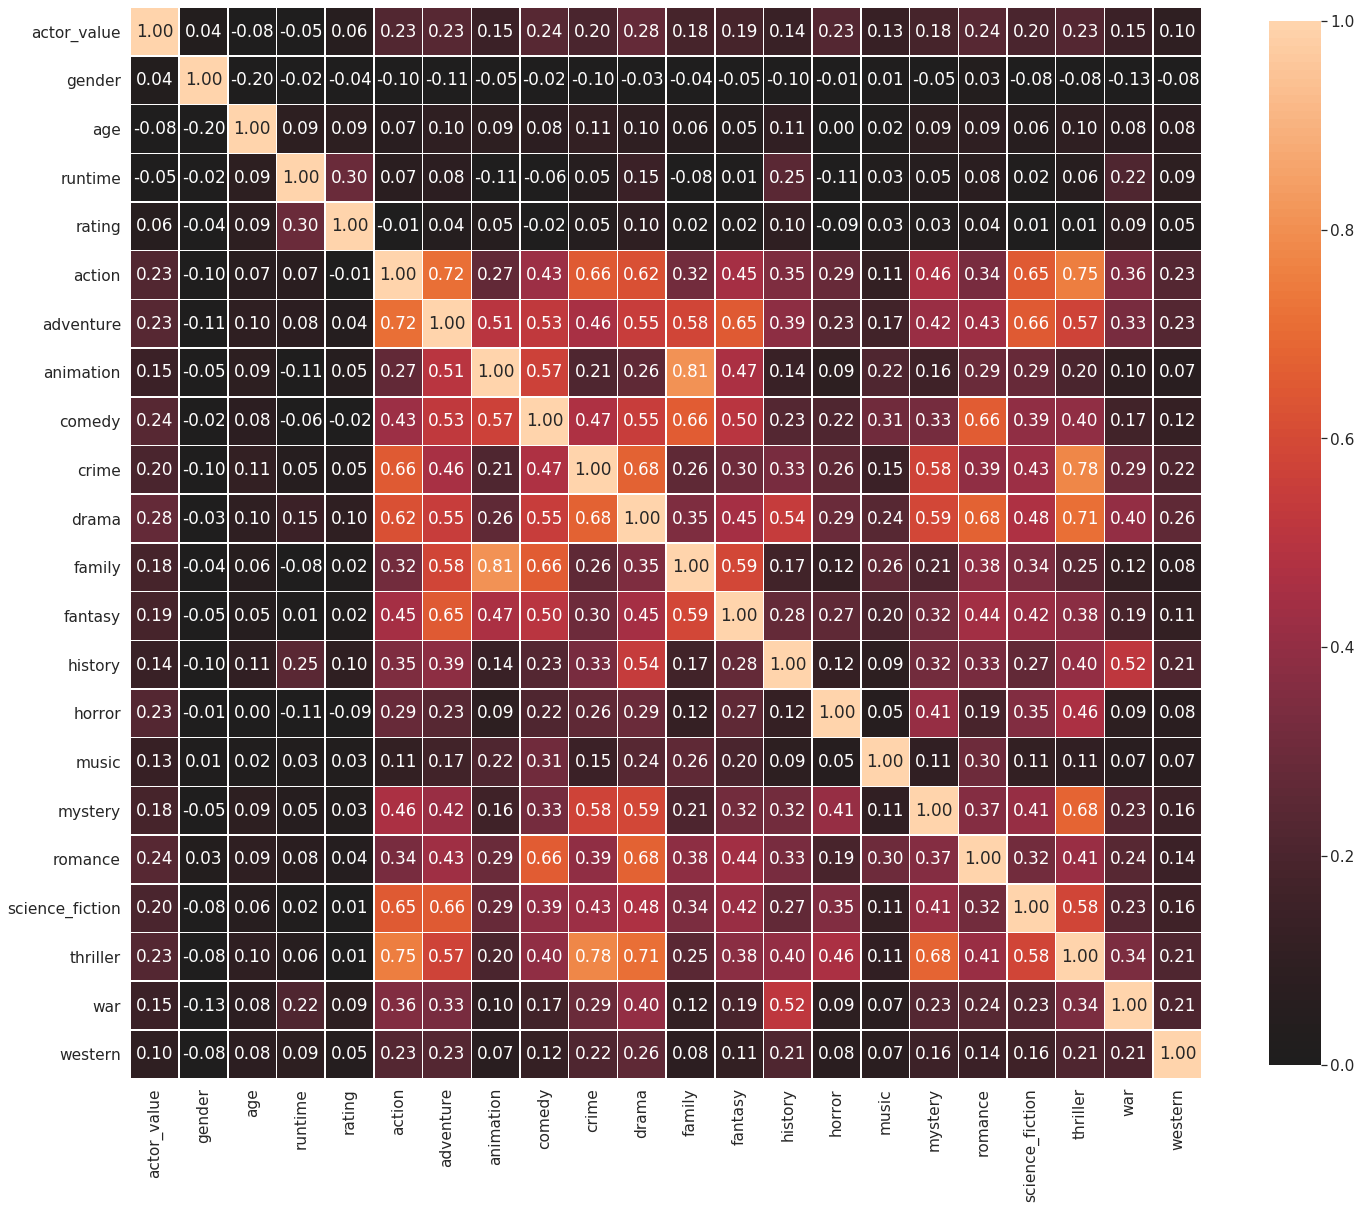

In [75]:
# plot correlations for dataset with natural log of full target
plot_correlations(log_all_df)

In [76]:
# separate data into features and target
X_log_all = log_all_df.drop('actor_value', axis=1)
y_log_all = log_all_df['actor_value']

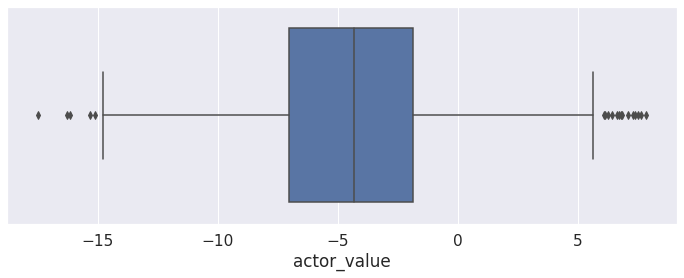

In [77]:
# plot target quartiles and outliers
sns.boxplot(y_log_all);

In [78]:
# get range of natural log of full target
min(y_log_all), max(y_log_all)

(-17.50839803347575, 7.867967753743332)

OLS-Natural Log All Target

In [79]:
# get OLS fitted regressor for log of full target
ols_model_log_all = get_ols_model(X_log_all, y_log_all)

In [80]:
# get OLS results for log of full target
print(ols_model_log_all.summary())

                                 OLS Regression Results                                
Dep. Variable:            actor_value   R-squared (uncentered):                   0.672
Model:                            OLS   Adj. R-squared (uncentered):              0.671
Method:                 Least Squares   F-statistic:                              1452.
Date:                Wed, 24 Jun 2020   Prob (F-statistic):                        0.00
Time:                        15:39:58   Log-Likelihood:                         -38726.
No. Observations:               14930   AIC:                                  7.749e+04
Df Residuals:                   14909   BIC:                                  7.765e+04
Df Model:                          21                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

In [81]:
# get OLS scores for log of full target
get_scores(X_log_all, y_log_all, ols_model_log_all)

'Root MSE: 3.20, STD Target: 3.47, Adj. R2: 0.1295'

RFR-Natural Log All Target

In [82]:
# instanciate base model for natural log of full target and get parameters
base_model_log_all = get_base_model(X_log_all, y_log_all)
get_params(base_model_log_all)

max_depth            None
max_features         auto
min_samples_leaf        1
min_samples_split       2
n_estimators          100
Name: full_target, dtype: object

In [83]:
# base model scores for natural log of full target
get_scores(X_log_all, y_log_all, base_model_log_all)

'Root MSE: 3.11, STD Target: 3.47, Adj. R2: 0.1778'

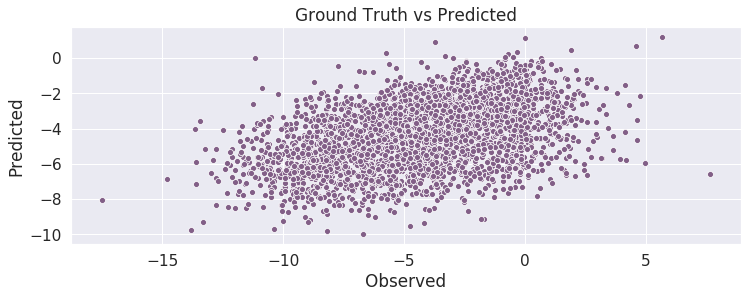

In [84]:
# plot base model observed vs. predictions using natural log of full target
plot_predictions(X_log_all, y_log_all, base_model_log_all)

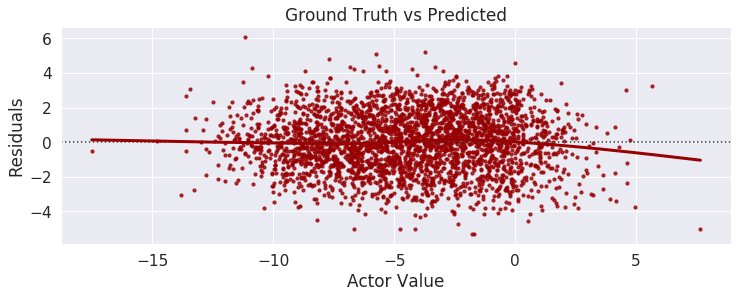

In [85]:
# plot residuals for base model using natural log of full target
plot_residuals(X_log_all, y_log_all, base_model_log_all)

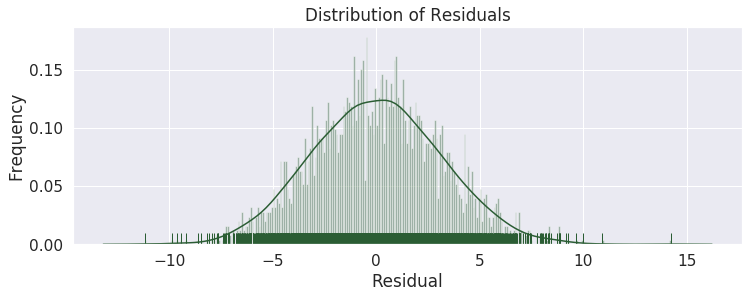

In [86]:
# plot residuals distribution for base model using natural log of full target
plot_residual_distribution(X_log_all, y_log_all, base_model_log_all)

The models fit the combined data similarly to the divided data.

> **LOG NO OUTLIERS TARGET**

I will drop the outliers from this dataset, nudging the scores toward being a little more favorable.

In [87]:
# create Z-score Series
z_score = (
    log_all_df["actor_value"] - np.mean(
        log_all_df["actor_value"])) / np.std(log_all_df["actor_value"])
# get number of outlier observations according to z-score
(np.absolute(z_score) > 3).sum()

19

In [88]:
# find percentage of outliers in datset having Z-Score > 3
(np.absolute(z_score) > 3).sum() / log_all_df.shape[0] * 100

0.12726054922973878

In [89]:
# drop outliers target
log_no_df = log_all_df.drop(
    index=log_all_df.loc[np.absolute(
        np.divide(
            np.subtract(
                log_all_df["actor_value"], np.mean(log_all_df["actor_value"])
            ), np.std(log_all_df["actor_value"]))) > 3].index)

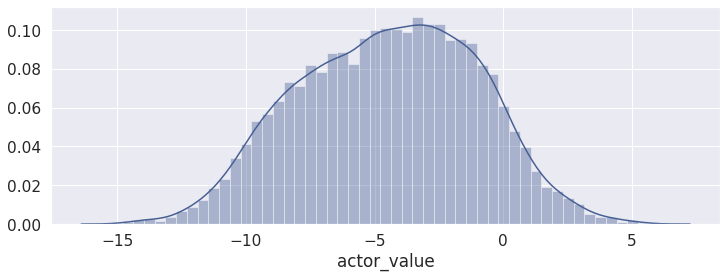

In [90]:
# plot distribution of log of no outliers target
sns.distplot(log_no_df['actor_value']);

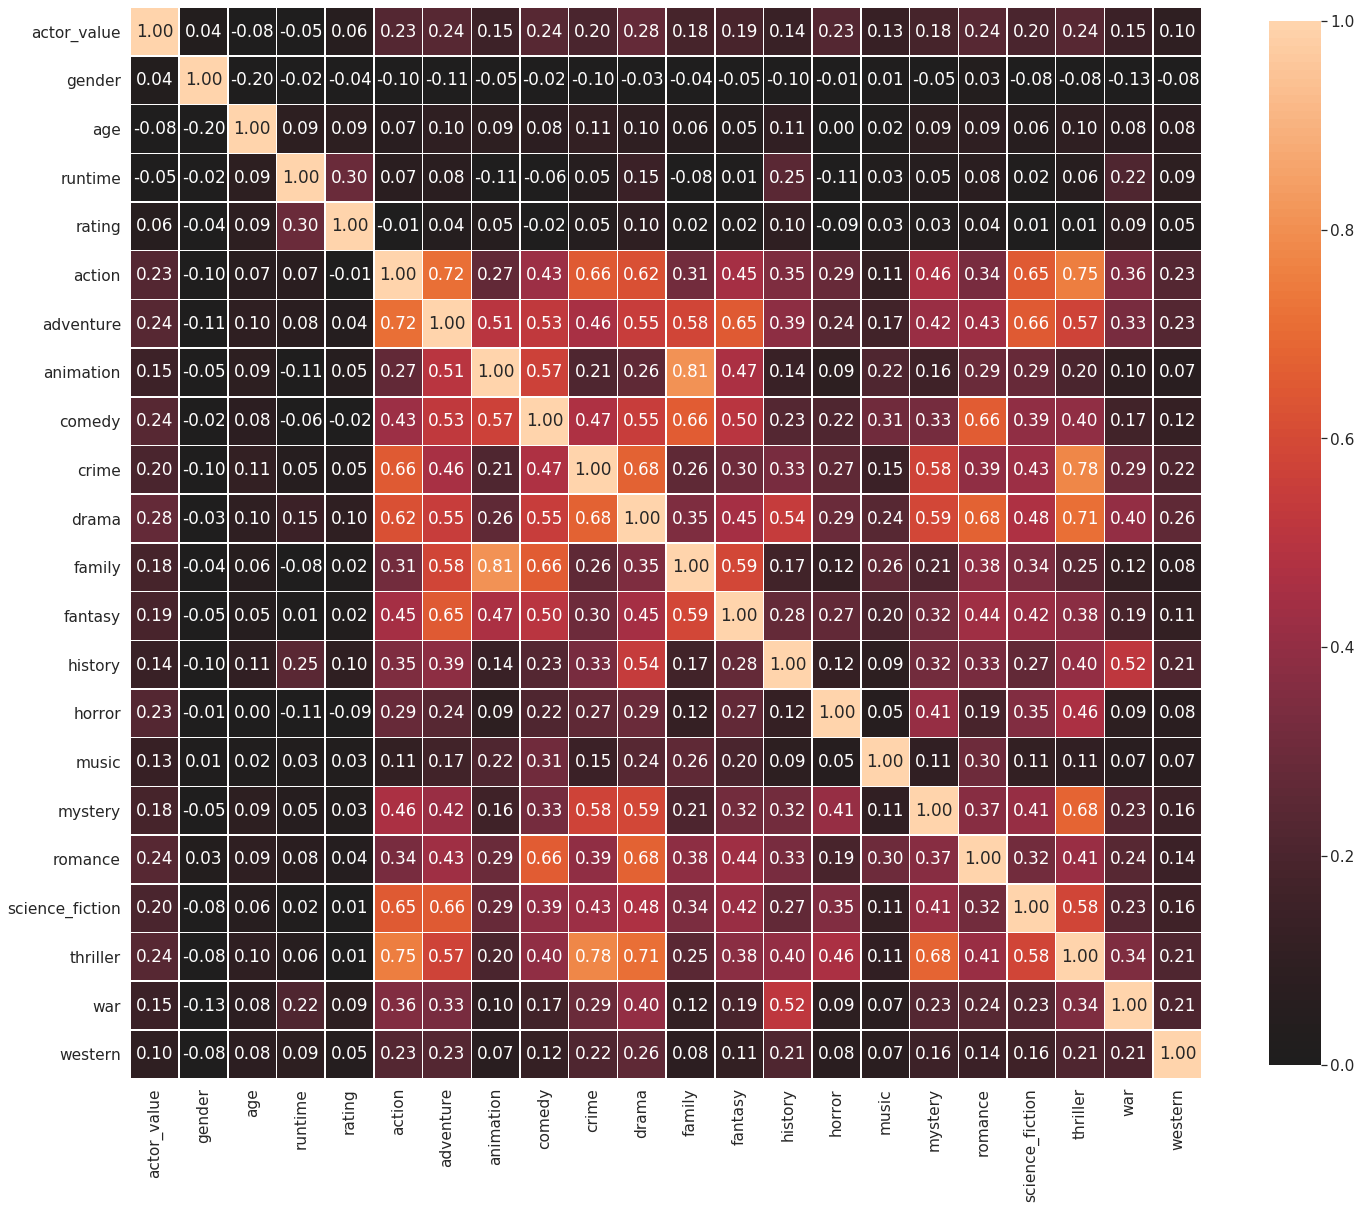

In [91]:
# plot correlations for dataset with log of no outliers target
plot_correlations(log_no_df)

In [92]:
# separate data into features and target
X_log_no = log_no_df.drop('actor_value', axis=1)
y_log_no = log_no_df['actor_value']

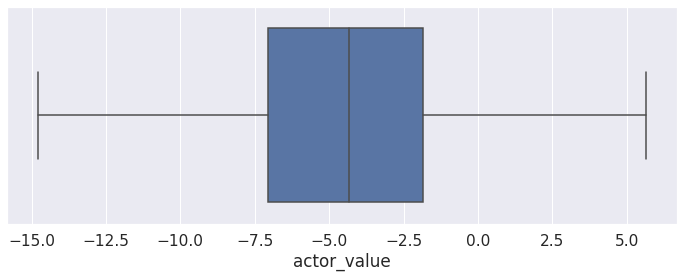

In [93]:
# plot target quartiles and outliers
sns.boxplot(y_log_no);

In [94]:
# get range of natural log of no outliers target
min(y_log_no), max(y_log_no)

(-14.794741089612303, 5.654337719999155)

OLS-Natural Log No Outliers Target

In [95]:
# get OLS fitted regressor for log no outliers target
ols_model_log_no = get_ols_model(X_log_no, y_log_no)

In [96]:
# get OLS results for log no outliers target
print(ols_model_log_no.summary())

                                 OLS Regression Results                                
Dep. Variable:            actor_value   R-squared (uncentered):                   0.675
Model:                            OLS   Adj. R-squared (uncentered):              0.675
Method:                 Least Squares   F-statistic:                              1474.
Date:                Wed, 24 Jun 2020   Prob (F-statistic):                        0.00
Time:                        15:40:07   Log-Likelihood:                         -38575.
No. Observations:               14911   AIC:                                  7.719e+04
Df Residuals:                   14890   BIC:                                  7.735e+04
Df Model:                          21                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

In [97]:
# get OLS scores for log no outliers target
get_scores(X_log_no, y_log_no, ols_model_log_no)

'Root MSE: 3.19, STD Target: 3.45, Adj. R2: 0.1409'

RFR-Natural Log No Outliers Target

In [98]:
# instanciate base model for natural log of no outliers target and get parameters
base_model_log_no = get_base_model(X_log_no, y_log_no)
get_params(base_model_log_no)

max_depth            None
max_features         auto
min_samples_leaf        1
min_samples_split       2
n_estimators          100
Name: full_target, dtype: object

In [99]:
# base model scores for natural log of no outliers target
get_scores(X_log_no, y_log_no, base_model_log_no)

'Root MSE: 3.07, STD Target: 3.45, Adj. R2: 0.2046'

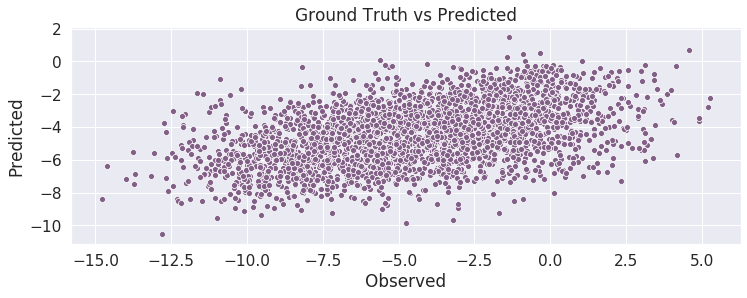

In [100]:
# plot base model observed vs. predictions using natural log of no outliers target
plot_predictions(X_log_no, y_log_no, base_model_log_no)

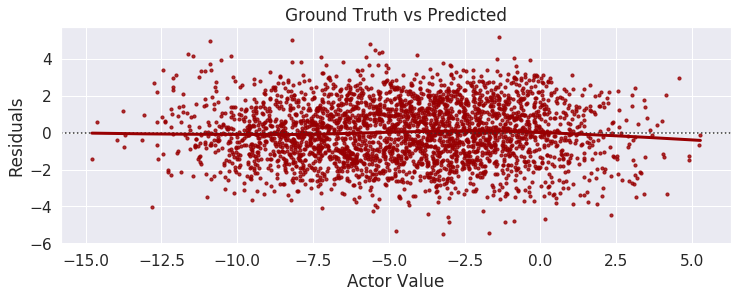

In [101]:
# plot residuals for base model using natural log of no outliers target
plot_residuals(X_log_no, y_log_no, base_model_log_no)

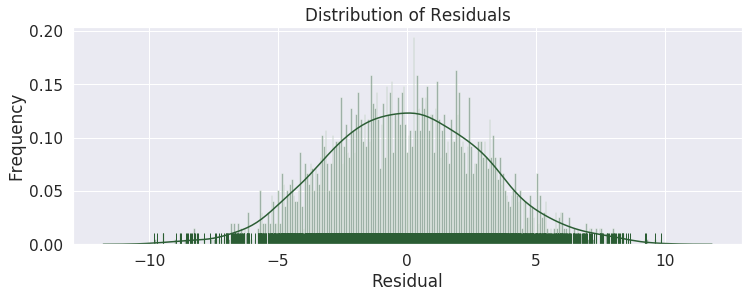

In [102]:
# plot residuals distribution for base model using natural log of no outliers target
plot_residual_distribution(X_log_no, y_log_no, base_model_log_no)

This is the optimal target.

> **RANDOM GRID SEARCH**

I will use a random grid search to tune the hyperparameters.

In [103]:
# split data into train/validate set and final test set for best target
X_train, X_test, y_train, y_test = train_test_split(
    X_log_no, y_log_no, test_size=0.2, random_state=27)

In [104]:
# create initial parameter search grid
random_grid_1 = {
    'max_depth': [int(x) for x in np.linspace(10, 100, num=10)] + [None],
    'max_features': [int(x) for x in np.linspace(1, 10, num=10)],
    'min_samples_leaf': [int(x) for x in np.linspace(1, 10, num=10)],
    'min_samples_split': [int(x) for x in np.linspace(1, 10, num=10)],
    'n_estimators': [int(x) for x in np.linspace(600, 2400, num=10)]}
random_grid_1

{'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'min_samples_split': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'n_estimators': [600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400]}

In [105]:
def get_best_model(train_features, train_target, grid):
    """Return best model for randomized hyperparameter grid search"""
    # instanciate model
    rfr = RandomForestRegressor(random_state=27)
    # instanciate grid search model
    rfr_random = RandomizedSearchCV(
        estimator=rfr, param_distributions=grid, n_iter=100, cv=3, 
        scoring='neg_root_mean_squared_error', verbose=1, 
        random_state=27, n_jobs=-1, return_train_score=True)
    # fit search model
    rfr_random.fit(train_features, train_target)
    # get best model
    best_model = rfr_random.best_estimator_
    # get cross-validation results
    results_df = pd.DataFrame(
        rfr_random.cv_results_).set_index(
        'rank_test_score', drop=True).sort_index()
    
    return best_model, results_df

In [106]:
# get 1st best model and results
best_model_1, results_1 = get_best_model(X_train, y_train, random_grid_1)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.2min finished


In [107]:
# get parameters
get_params(best_model_1)

max_depth              70
max_features            4
min_samples_leaf        1
min_samples_split       9
n_estimators         2200
Name: full_target, dtype: object

In [108]:
# get training scores
get_scores(X_train, y_train, best_model_1)

'Root MSE: 2.04, STD Target: 3.45, Adj. R2: 0.6413'

In [109]:
def get_results(results):
    new_cols = [i[i.startswith('param_') and len('param_'):] 
                for i 
                in results.columns.to_list()]
    my_results = results.rename(dict(zip(results.columns, new_cols)), axis=1)
    my_results.index.names = ['rank']
    slices = [13, 18, 8, 7, 6, 5, 4]
    
    return my_results.head(15).iloc[:, slices]

In [110]:
# get grid results
get_results(results_1)

mean_test_score  mean_train_score max_depth max_features  \
rank                                                             
1           -3.025853         -2.060787        70            4   
2           -3.027106         -2.256596        80            2   
3           -3.027494         -1.982471       100            4   
4           -3.027612         -1.816710        60            4   
5           -3.028293         -1.609075        50            3   
6           -3.030627         -2.409378      None            3   
7           -3.031841         -2.215398        60            5   
8           -3.032682         -2.439303        20            3   
9           -3.033924         -2.450099        30            4   
10          -3.034998         -2.420096        20            5   
11          -3.035675         -2.112108        30            6   
12          -3.036161         -2.557996        30            3   
13          -3.036316         -1.920562       100            7   
14          -3.036386         -2.564930        20            3   
15          -3.036544         -1.850194        70            7   

     min_samples_leaf min_samples_split n_estimators  
rank                                                  
1                   1                 9         2200  
2                   1                10         1400  
3                   2                 2         2200  
4                   1                 6         1400  
5                   1                 4         2000  
6                   3                 2          600  
7                   3                 7         2400  
8                   2                 8          600  
9                   4                 3         1000  
10                  4                 7         2400  
11                  3                 2         1600  
12                  4                 3         1200  
13                  1                 9         1600  
14                  3                10         1000  
15                  1                 8         1800

In [111]:
def plot_results_param(parameter, results):
    """Returns plot of average train and test scores for random parameter"""
    plt.plot(results['param_' + parameter].sort_values(), 
             results['mean_train_score'] * -1, label='Train', color=mp.colors(2))
    plt.plot(results['param_' + parameter].sort_values(), 
             results['mean_test_score'] * -1, label='Test', color=mp.colors(4))
    
    plt.xlabel(parameter)
    plt.ylabel('Root Mean Squared Error')
    plt.legend()
    plt.title('Average Train and Test Scores');

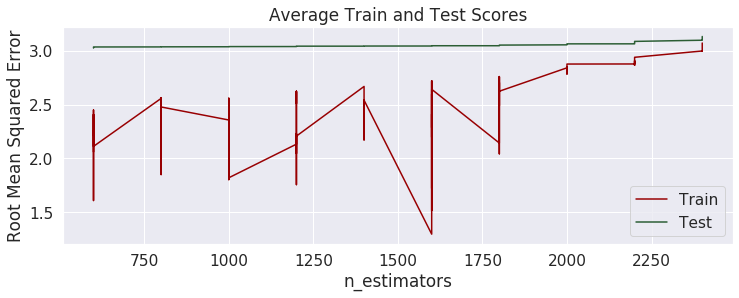

In [112]:
# plot tuning parameter
plot_results_param('n_estimators', results_1)

In [113]:
def get_cv_results(features, target, model):
    """Return CV average score, score range, and target standard deviation"""
    cv_results = cross_val_score(model, features, target, 
                                 scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
    global results
    results = np.round(np.sqrt(cv_results * -1), 5)
    results_range = (np.min(results), np.max(results))
    ave_result = np.round(np.sqrt(np.mean(cv_results) * -1), 5)
    std_target = np.round(np.std(y_log_no), 5)
        
    return f'Mean Score: {ave_result}, Range: {results_range}, Std Target: {std_target}'

In [114]:
# get cross-validation results
get_cv_results(X_train, y_train, best_model_1)

'Mean Score: 3.01454, Range: (2.89212, 3.13887), Std Target: 3.44769'

As can be expected, the model likes a lot of trees.<br>
I will keep the number of estimators high.

In [115]:
# trim n estimators
random_grid_2 = {
    'max_depth': [int(x) for x in np.linspace(10, 100, num=10)] + [None],
    'max_features': [int(x) for x in np.linspace(1, 10, num=10)],
    'min_samples_leaf': [int(x) for x in np.linspace(1, 10, num=10)],
    'min_samples_split': [int(x) for x in np.linspace(1, 10, num=10)],
    'n_estimators': [int(x) for x in np.linspace(2200, 2600, num=3)]}
random_grid_2

{'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'min_samples_split': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'n_estimators': [2200, 2400, 2600]}

In [116]:
# get next best model and results
best_model_2, results_2 = get_best_model(X_train, y_train, random_grid_2)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.4min finished


In [117]:
# get parameters
get_params(best_model_2)

max_depth              70
max_features            5
min_samples_leaf        2
min_samples_split       7
n_estimators         2600
Name: full_target, dtype: object

In [118]:
# get training scores
get_scores(X_train, y_train, best_model_2)

'Root MSE: 2.05, STD Target: 3.45, Adj. R2: 0.6376'

In [119]:
# get cross-validation results
get_cv_results(X_train, y_train, best_model_2)

'Mean Score: 3.02008, Range: (2.8956, 3.14435), Std Target: 3.44769'

In [120]:
# get grid results
get_results(results_2)

mean_test_score  mean_train_score max_depth max_features  \
rank                                                             
1           -3.029651         -2.062450        70            5   
2           -3.029810         -2.002260        70            5   
3           -3.030053         -2.116260        80            5   
4           -3.030528         -1.761046        90            5   
5           -3.031299         -1.876366       100            5   
6           -3.032088         -1.662435       100            2   
7           -3.033527         -2.468863        60            2   
8           -3.033987         -2.448463        80            4   
9           -3.033991         -2.501827        30            2   
10          -3.033999         -2.448428        40            4   
10          -3.033999         -2.448428        40            4   
12          -3.034663         -2.380498        70            5   
13          -3.035736         -2.555887        40            3   
14          -3.035842         -2.556157        60            3   
15          -3.036218         -1.850358      None            7   

     min_samples_leaf min_samples_split n_estimators  
rank                                                  
1                   2                 7         2600  
2                   2                 6         2200  
3                   2                 8         2200  
4                   1                 6         2200  
5                   2                 4         2600  
6                   1                 4         2400  
7                   2                 9         2400  
8                   4                 2         2200  
9                   2                10         2600  
10                  4                 3         2600  
10                  4                 6         2600  
12                  4                 9         2200  
13                  4                 4         2400  
14                  4                 4         2200  
15                  1                 8         2600

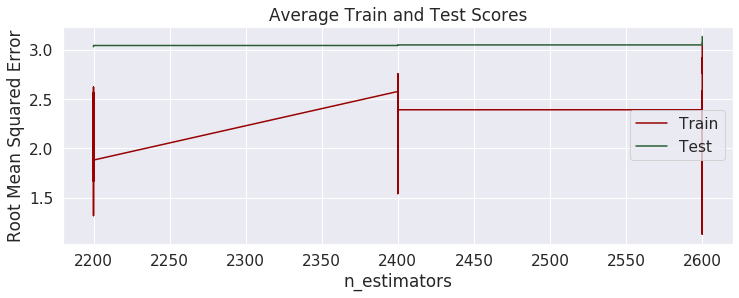

In [121]:
# plot tuning parameter
plot_results_param('n_estimators', results_2)

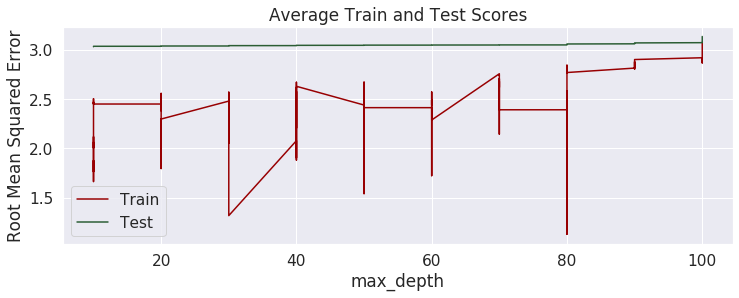

In [122]:
# plot tuning parameter
plot_results_param('max_depth', results_2)

In [123]:
# get cross-validation results
get_cv_results(X_train, y_train, best_model_2)

'Mean Score: 3.02008, Range: (2.8956, 3.14435), Std Target: 3.44769'

I will shift the max depth range to allow the trees to grow deeper.

In [124]:
# shift max depth
random_grid_3 = {
    'max_depth': [int(x) for x in np.linspace(60, 150, num=10)],
    'max_features': [int(x) for x in np.linspace(1, 10, num=10)],
    'min_samples_leaf': [int(x) for x in np.linspace(1, 10, num=10)],
    'min_samples_split': [int(x) for x in np.linspace(1, 10, num=10)],
    'n_estimators': [int(x) for x in np.linspace(2200, 2600, num=3)]}
random_grid_3

{'max_depth': [60, 70, 80, 90, 100, 110, 120, 130, 140, 150],
 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'min_samples_split': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'n_estimators': [2200, 2400, 2600]}

In [125]:
# get next best model and results
best_model_3, results_3 = get_best_model(X_train, y_train, random_grid_3)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.8min finished


In [126]:
# get parameters
get_params(best_model_3)

max_depth              70
max_features            4
min_samples_leaf        1
min_samples_split       5
n_estimators         2200
Name: full_target, dtype: object

In [127]:
# get training scores
get_scores(X_train, y_train, best_model_3)

'Root MSE: 1.68, STD Target: 3.45, Adj. R2: 0.7549'

In [128]:
# get grid results
get_results(results_3)

mean_test_score  mean_train_score max_depth max_features  \
rank                                                             
1           -3.027423         -1.701046        70            4   
2           -3.027467         -2.308321        60            3   
3           -3.027494         -1.982471       100            4   
4           -3.029651         -2.062450       120            5   
5           -3.030417         -1.937053        80            5   
6           -3.030528         -1.761046       140            5   
7           -3.031265         -1.876301        70            5   
8           -3.031976         -2.018741        80            6   
9           -3.032088         -1.662435       150            2   
10          -3.033527         -2.468863       110            2   
11          -3.033997         -2.448426        90            4   
11          -3.033997         -2.448426        90            4   
13          -3.034074         -2.448396        80            4   
14          -3.034898         -2.181632        60            6   
15          -3.035430         -1.372452        70            4   

     min_samples_leaf min_samples_split n_estimators  
rank                                                  
1                   1                 5         2200  
2                   2                 8         2600  
3                   2                 2         2200  
4                   2                 7         2600  
5                   2                 5         2400  
6                   1                 6         2200  
7                   2                 3         2400  
8                   1                10         2400  
9                   1                 4         2400  
10                  2                 9         2400  
11                  4                 6         2600  
11                  4                 3         2600  
13                  4                 8         2400  
14                  3                 8         2400  
15                  1                 3         2200

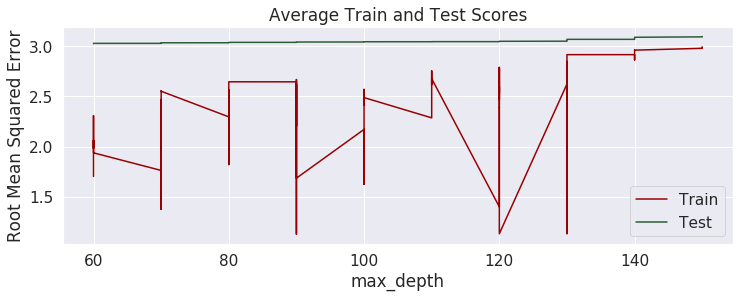

In [129]:
# plot tuning parameter
plot_results_param('max_depth', results_3)

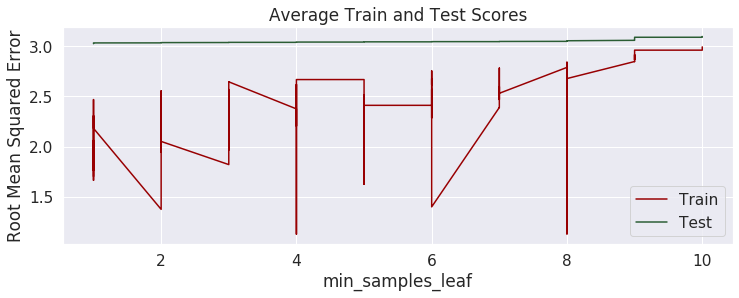

In [130]:
# plot tuning parameter
plot_results_param('min_samples_leaf', results_3)

In [131]:
# get cross-validation results
get_cv_results(X_train, y_train, best_model_3)

'Mean Score: 3.01636, Range: (2.89562, 3.13887), Std Target: 3.44769'

I made the range of max depth too high.<br>
I will reduce it.<br>
Also, I will limit the lower range of the leaf samples.

In [132]:
# trim max depth and min samples leaf
random_grid_4 = {
    'max_depth': [int(x) for x in np.linspace(60, 120, num=7)],
    'max_features': [int(x) for x in np.linspace(1, 10, num=10)],
    'min_samples_leaf': [int(x) for x in np.linspace(1, 3, num=3)],
    'min_samples_split': [int(x) for x in np.linspace(1, 10, num=10)],
    'n_estimators': [int(x) for x in np.linspace(2200, 2600, num=3)]}
random_grid_4

{'max_depth': [60, 70, 80, 90, 100, 110, 120],
 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'min_samples_leaf': [1, 2, 3],
 'min_samples_split': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'n_estimators': [2200, 2400, 2600]}

In [133]:
# get next best model and results
best_model_4, results_4 = get_best_model(X_train, y_train, random_grid_4)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  7.5min finished


In [134]:
# get parameters
get_params(best_model_4)

max_depth              60
max_features            3
min_samples_leaf        1
min_samples_split       7
n_estimators         2600
Name: full_target, dtype: object

In [135]:
# get training scores
get_scores(X_train, y_train, best_model_4)

'Root MSE: 1.95, STD Target: 3.45, Adj. R2: 0.6705'

In [136]:
# get grid results
get_results(results_4)

mean_test_score  mean_train_score max_depth max_features  \
rank                                                             
1           -3.025208         -1.978419        60            3   
2           -3.026098         -2.218202        80            3   
3           -3.027178         -2.198711        60            2   
4           -3.027194         -2.118671       110            3   
5           -3.027293         -2.118550       110            3   
5           -3.027293         -2.118550       100            3   
7           -3.027375         -1.982330        70            4   
8           -3.027402         -1.982418       110            4   
9           -3.027494         -1.982471        80            4   
10          -3.027550         -2.308196        70            3   
11          -3.029277         -1.855153        60            5   
12          -3.029441         -2.062533       120            5   
13          -3.029672         -2.275514       100            2   
14          -3.029741         -2.164687       100            5   
15          -3.030021         -2.116197        80            5   

     min_samples_leaf min_samples_split n_estimators  
rank                                                  
1                   1                 7         2600  
2                   2                 6         2600  
3                   1                 9         2200  
4                   2                 3         2600  
5                   2                 4         2400  
5                   2                 3         2400  
7                   2                 2         2400  
8                   2                 4         2600  
9                   2                 4         2200  
10                  2                 8         2400  
11                  1                 7         2400  
12                  2                 7         2200  
13                  2                 3         2200  
14                  2                 9         2600  
15                  2                 8         2400

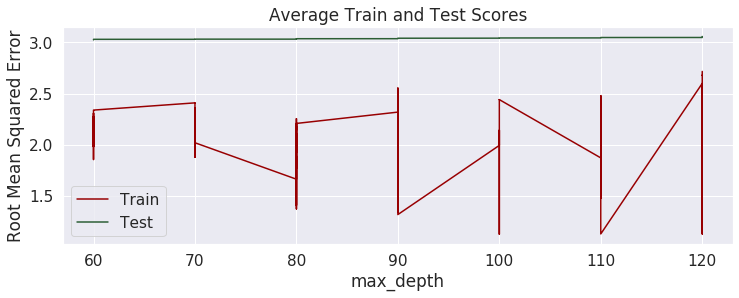

In [137]:
# plot tuning parameter
plot_results_param('max_depth', results_4)

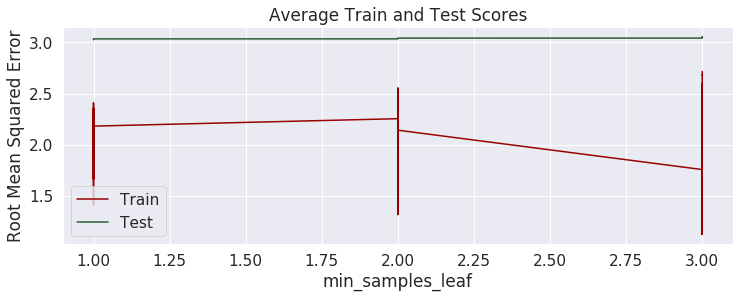

In [138]:
# plot tuning parameter
plot_results_param('min_samples_leaf', results_4)

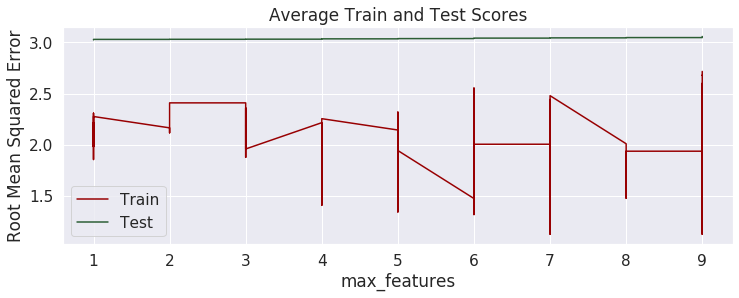

In [139]:
# plot tuning parameter
plot_results_param('max_features', results_4)

In [140]:
# get cross-validation results
get_cv_results(X_train, y_train, best_model_4)

'Mean Score: 3.01396, Range: (2.89193, 3.1367), Std Target: 3.44769'

I will limit max features to select to the optimal range.<br>
Also, I am going to restrict the range of the leaf samples a bit more.

In [141]:
# trim max features and min samples leaf
random_grid_5 = {
    'max_depth': [int(x) for x in np.linspace(60, 120, num=7)],
    'max_features': [int(x) for x in np.linspace(2, 4, num=3)],
    'min_samples_leaf': [int(x) for x in np.linspace(1, 2, num=2)],
    'min_samples_split': [int(x) for x in np.linspace(1, 10, num=10)],
    'n_estimators': [int(x) for x in np.linspace(2200, 2600, num=3)]}
random_grid_5

{'max_depth': [60, 70, 80, 90, 100, 110, 120],
 'max_features': [2, 3, 4],
 'min_samples_leaf': [1, 2],
 'min_samples_split': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'n_estimators': [2200, 2400, 2600]}

In [142]:
# get next best model and results
best_model_5, results_5 = get_best_model(X_train, y_train, random_grid_5)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.9min finished


In [143]:
# get parameters
get_params(best_model_5)

max_depth              70
max_features            3
min_samples_leaf        1
min_samples_split      10
n_estimators         2600
Name: full_target, dtype: object

In [144]:
# get training scores
get_scores(X_train, y_train, best_model_5)

'Root MSE: 2.16, STD Target: 3.45, Adj. R2: 0.5978'

In [145]:
# get grid results
get_results(results_5)

mean_test_score  mean_train_score max_depth max_features  \
rank                                                             
1           -3.024574         -2.185182        70            3   
2           -3.025241         -2.059139       120            3   
3           -3.025360         -1.881003       100            3   
3           -3.025360         -1.881003        60            3   
5           -3.025615         -2.060874        60            4   
6           -3.025828         -2.119840       110            4   
6           -3.025828         -2.119840        90            4   
8           -3.025887         -2.119789       100            4   
8           -3.025887         -2.119789        70            4   
10          -3.026098         -2.218202       120            3   
11          -3.026180         -2.218011       120            3   
11          -3.026180         -2.218011       110            3   
13          -3.026346         -2.037676        90            4   
13          -3.026346         -2.037676       110            4   
15          -3.026399         -2.166688        70            3   

     min_samples_leaf min_samples_split n_estimators  
rank                                                  
1                   1                10         2600  
2                   1                 8         2400  
3                   1                 6         2600  
3                   1                 6         2600  
5                   1                 9         2600  
6                   1                10         2200  
6                   1                10         2200  
8                   1                10         2600  
8                   1                10         2600  
10                  2                 6         2600  
11                  2                 6         2400  
11                  2                 6         2400  
13                  2                 5         2200  
13                  2                 5         2200  
15                  2                 5         2600

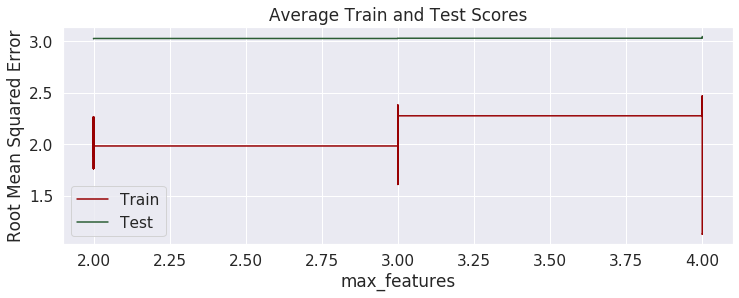

In [146]:
# plot tuning parameter
plot_results_param('max_features', results_5)

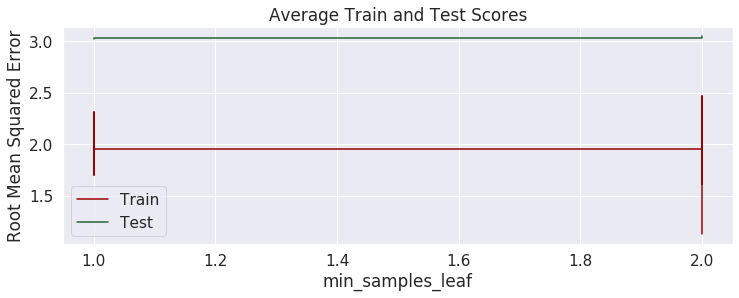

In [147]:
# plot tuning parameter
plot_results_param('min_samples_leaf', results_5)

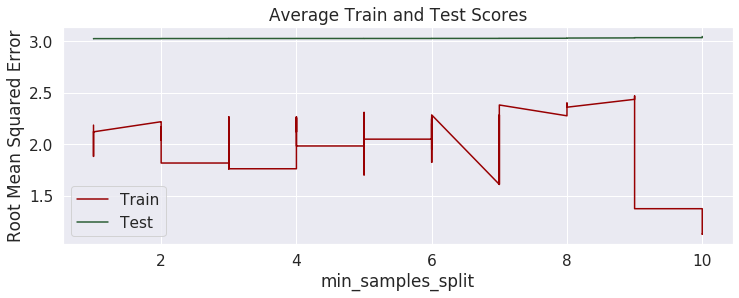

In [148]:
# plot tuning parameter
plot_results_param('min_samples_split', results_5)

In [149]:
# get cross-validation results
get_cv_results(X_train, y_train, best_model_5)

'Mean Score: 3.01469, Range: (2.89074, 3.13454), Std Target: 3.44769'

Now, I will make the min samples to split more optimal.

In [150]:
# trim min samples split
random_grid_6 = {
    'max_depth': [int(x) for x in np.linspace(60, 120, num=7)],
    'max_features': [int(x) for x in np.linspace(2, 4, num=3)],
    'min_samples_leaf': [int(x) for x in np.linspace(1, 2, num=2)],
    'min_samples_split': [int(x) for x in np.linspace(6, 10, num=5)],
    'n_estimators': [int(x) for x in np.linspace(2200, 2600, num=3)]}
random_grid_6

{'max_depth': [60, 70, 80, 90, 100, 110, 120],
 'max_features': [2, 3, 4],
 'min_samples_leaf': [1, 2],
 'min_samples_split': [6, 7, 8, 9, 10],
 'n_estimators': [2200, 2400, 2600]}

In [151]:
# get next best model and results
best_model_6, results_6 = get_best_model(X_train, y_train, random_grid_6)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.1min finished


In [152]:
# get parameters
get_params(best_model_6)

max_depth              60
max_features            3
min_samples_leaf        1
min_samples_split       9
n_estimators         2200
Name: full_target, dtype: object

In [153]:
# get training scores
get_scores(X_train, y_train, best_model_6)

'Root MSE: 2.10, STD Target: 3.45, Adj. R2: 0.6198'

In [154]:
# get grid results
get_results(results_6)

mean_test_score  mean_train_score max_depth max_features  \
rank                                                             
1           -3.024464         -2.127487        60            3   
2           -3.024472         -2.127348        60            3   
2           -3.024472         -2.127348        90            3   
2           -3.024472         -2.127348        80            3   
5           -3.024574         -2.185182       120            3   
5           -3.024574         -2.185182       110            3   
7           -3.024583         -2.185149       100            3   
8           -3.024664         -2.185245        70            3   
8           -3.024664         -2.185245        80            3   
10          -3.025059         -2.059199       120            3   
11          -3.025168         -2.059193        80            3   
12          -3.025208         -1.978419        90            3   
13          -3.025241         -2.059139        60            3   
13          -3.025241         -2.059139        70            3   
15          -3.025272         -1.881058        80            3   

     min_samples_leaf min_samples_split n_estimators  
rank                                                  
1                   1                 9         2200  
2                   1                 9         2400  
2                   1                 9         2400  
2                   1                 9         2400  
5                   1                10         2600  
5                   1                10         2600  
7                   1                10         2400  
8                   1                10         2200  
8                   1                10         2200  
10                  1                 8         2600  
11                  1                 8         2200  
12                  1                 7         2600  
13                  1                 8         2400  
13                  1                 8         2400  
15                  1                 6         2200

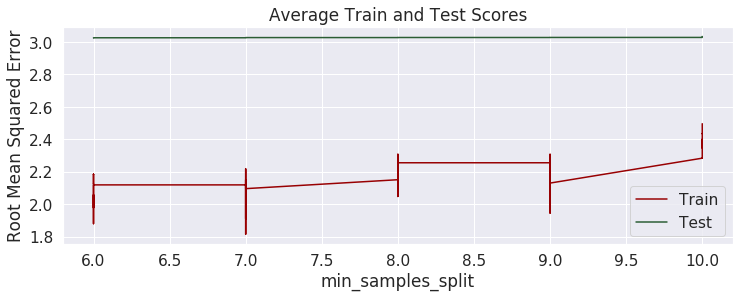

In [155]:
# plot tuning parameter
plot_results_param('min_samples_split', results_6)

In [156]:
# get cross-validation results
get_cv_results(X_train, y_train, best_model_6)

'Mean Score: 3.01348, Range: (2.89087, 3.13462), Std Target: 3.44769'

The grid is almost optimized.<br>
I will reduce the range on all parameters except the number of trees.

In [157]:
# trim max depth, max features, min samples leaf, and min samples split
random_grid_7 = {
    'max_depth': [int(x) for x in np.linspace(50, 80, num=4)],
    'max_features': [int(3)],
    'min_samples_leaf': [int(1)],
    'min_samples_split': [int(x) for x in np.linspace(9, 10, num=2)],
    'n_estimators': [int(x) for x in np.linspace(2200, 2600, num=3)]}
random_grid_7

{'max_depth': [50, 60, 70, 80],
 'max_features': [3],
 'min_samples_leaf': [1],
 'min_samples_split': [9, 10],
 'n_estimators': [2200, 2400, 2600]}

In [158]:
# get next best model and results
best_model_7, results_7 = get_best_model(X_train, y_train, random_grid_7)

/home/lord_black/anaconda3/envs/movieCap1/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 24 is smaller than n_iter=100. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  1.5min finished


In [159]:
# get parameters
get_params(best_model_7)

max_depth              50
max_features            3
min_samples_leaf        1
min_samples_split       9
n_estimators         2600
Name: full_target, dtype: object

In [160]:
# get training scores
get_scores(X_train, y_train, best_model_7)

'Root MSE: 2.10, STD Target: 3.45, Adj. R2: 0.6197'

In [161]:
# get grid results
get_results(results_7)

mean_test_score  mean_train_score max_depth max_features  \
rank                                                             
1           -3.024277         -2.127467        50            3   
1           -3.024277         -2.127467        80            3   
1           -3.024277         -2.127467        60            3   
1           -3.024277         -2.127467        70            3   
5           -3.024464         -2.127487        50            3   
5           -3.024464         -2.127487        80            3   
5           -3.024464         -2.127487        60            3   
5           -3.024464         -2.127487        70            3   
9           -3.024472         -2.127348        50            3   
9           -3.024472         -2.127348        80            3   
9           -3.024472         -2.127348        60            3   
9           -3.024472         -2.127348        70            3   
13          -3.024574         -2.185182        70            3   
13          -3.024574         -2.185182        60            3   
13          -3.024574         -2.185182        80            3   

     min_samples_leaf min_samples_split n_estimators  
rank                                                  
1                   1                 9         2600  
1                   1                 9         2600  
1                   1                 9         2600  
1                   1                 9         2600  
5                   1                 9         2200  
5                   1                 9         2200  
5                   1                 9         2200  
5                   1                 9         2200  
9                   1                 9         2400  
9                   1                 9         2400  
9                   1                 9         2400  
9                   1                 9         2400  
13                  1                10         2600  
13                  1                10         2600  
13                  1                10         2600

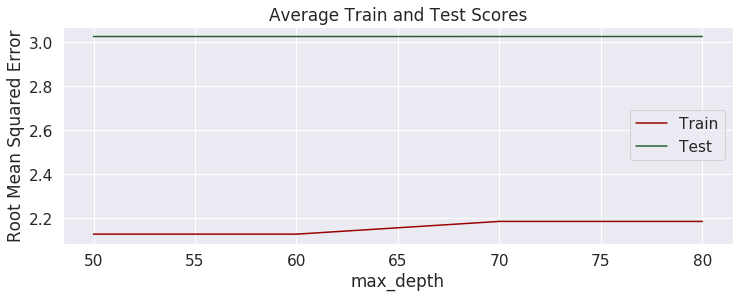

In [162]:
# plot tuning parameter
plot_results_param('max_depth', results_7)

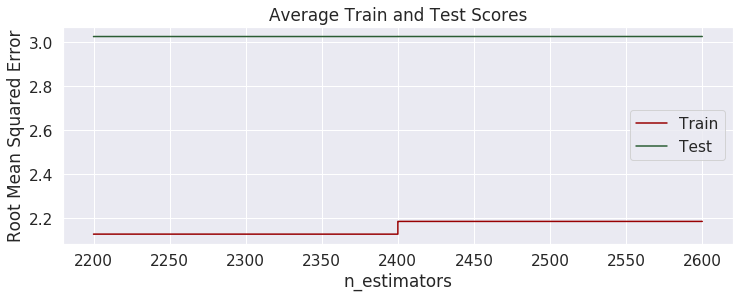

In [163]:
# plot tuning parameter
plot_results_param('n_estimators', results_7)

In [164]:
# get cross-validation results
get_cv_results(X_train, y_train, best_model_7)

'Mean Score: 3.01336, Range: (2.89063, 3.13449), Std Target: 3.44769'

After finding the optimal values for three of the parameters, I have a lot of time to kill for the final run.<br>
I will open up the depth and number of trees to see if there is any benefit.

In [165]:
# trim min samples split and expand max depth and n estimators
random_grid_8 = {
    'max_depth': [int(x) for x in np.linspace(40, 90, num=6)],
    'max_features': [int(3)],
    'min_samples_leaf': [int(1)],
    'min_samples_split': [int(9)],
    'n_estimators': [int(x) for x in np.linspace(2100, 3000, num=10)]}
random_grid_8

{'max_depth': [40, 50, 60, 70, 80, 90],
 'max_features': [3],
 'min_samples_leaf': [1],
 'min_samples_split': [9],
 'n_estimators': [2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000]}

In [166]:
# get final best model and results
best_model_8, results_8 = get_best_model(X_train, y_train, random_grid_8)

/home/lord_black/anaconda3/envs/movieCap1/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 60 is smaller than n_iter=100. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  4.0min finished


In [167]:
# get parameters
get_params(best_model_8)

max_depth              50
max_features            3
min_samples_leaf        1
min_samples_split       9
n_estimators         3000
Name: full_target, dtype: object

In [168]:
# get training scores
get_scores(X_train, y_train, best_model_8)

'Root MSE: 2.10, STD Target: 3.45, Adj. R2: 0.6197'

In [169]:
# get grid results
get_results(results_8)

mean_test_score  mean_train_score max_depth max_features  \
rank                                                             
1           -3.024246         -2.127398        60            3   
1           -3.024246         -2.127398        80            3   
1           -3.024246         -2.127398        70            3   
1           -3.024246         -2.127398        50            3   
1           -3.024246         -2.127398        90            3   
6           -3.024263         -2.127504        60            3   
6           -3.024263         -2.127504        80            3   
6           -3.024263         -2.127504        70            3   
6           -3.024263         -2.127504        90            3   
6           -3.024263         -2.127504        50            3   
11          -3.024277         -2.127467        90            3   
11          -3.024277         -2.127467        80            3   
11          -3.024277         -2.127467        50            3   
11          -3.024277         -2.127467        60            3   
11          -3.024277         -2.127467        70            3   

     min_samples_leaf min_samples_split n_estimators  
rank                                                  
1                   1                 9         3000  
1                   1                 9         3000  
1                   1                 9         3000  
1                   1                 9         3000  
1                   1                 9         3000  
6                   1                 9         2800  
6                   1                 9         2800  
6                   1                 9         2800  
6                   1                 9         2800  
6                   1                 9         2800  
11                  1                 9         2600  
11                  1                 9         2600  
11                  1                 9         2600  
11                  1                 9         2600  
11                  1                 9         2600

Depth does not seem to matter at this point.<br>
Keeping all other parameters held constant, the model likes a larger forest, which is expected.

This is my best model to evaluate with the holdout data.

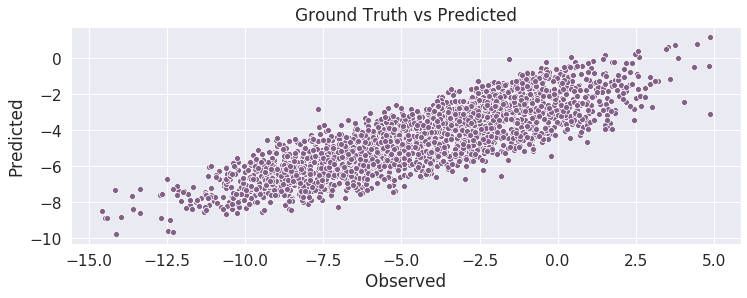

In [170]:
# plot base model observed vs. predictions using natural log of no outliers target
plot_predictions(X_train, y_train, best_model_8)

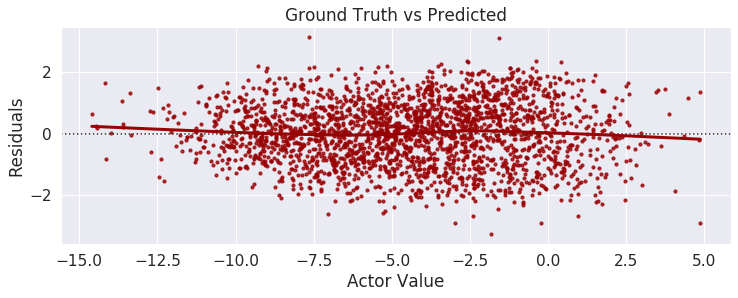

In [171]:
# plot residuals for base model using natural log of no outliers target
plot_residuals(X_train, y_train, best_model_8)

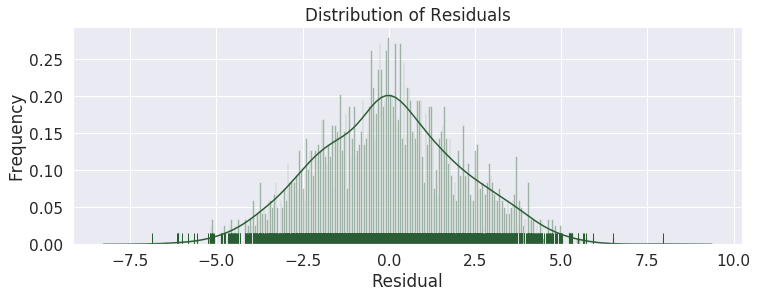

In [172]:
# plot residuals for base model using natural log of no outliers target
plot_residual_distribution(X_train, y_train, best_model_8)

The residuals are well behaved.

In [173]:
# get cross-validation results
get_cv_results(X_train, y_train, best_model_8)

'Mean Score: 3.01333, Range: (2.89068, 3.13432), Std Target: 3.44769'

In [174]:
# create DataFrame to hold all best scores
mean_scores_df = pd.DataFrame(columns=['mean_test_score', 'mean_train_score'])
best_cv_results = []
for i in range(1, 9):
    best_cv_results.append('results_' + str(i))
    mean_scores_df.loc[i] = [globals()['results_' + str(i)]['mean_test_score']
                             .iloc[0] * -1, 
                             globals()['results_' + str(i)]['mean_train_score']
                             .iloc[0] * -1]
mean_scores_df

mean_test_score  mean_train_score
1         3.025853          2.060787
2         3.029651          2.062450
3         3.027423          1.701046
4         3.025208          1.978419
5         3.024574          2.185182
6         3.024464          2.127487
7         3.024277          2.127467
8         3.024246          2.127398

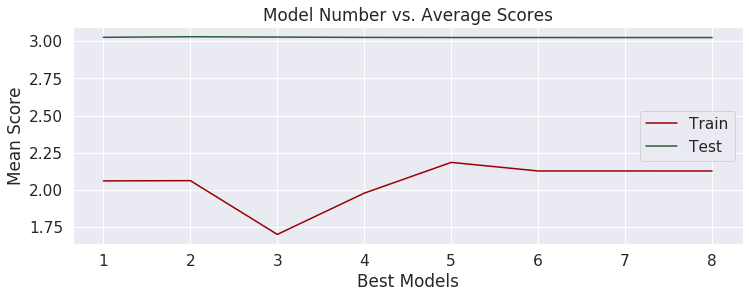

In [175]:
# plot average train and test scores
sns.lineplot(x=mean_scores_df.index, 
             y=mean_scores_df['mean_train_score'], 
             label=('Train'), color=mp.colors(2))
sns.lineplot(x=mean_scores_df.index, 
             y=mean_scores_df['mean_test_score'], 
             label=('Test'), color=mp.colors(4))

plt.xlabel('Best Models')
plt.ylabel('Mean Score')
plt.legend(loc=7)

plt.title('Model Number vs. Average Scores');

The model reached a level of least overfitting at model 5.

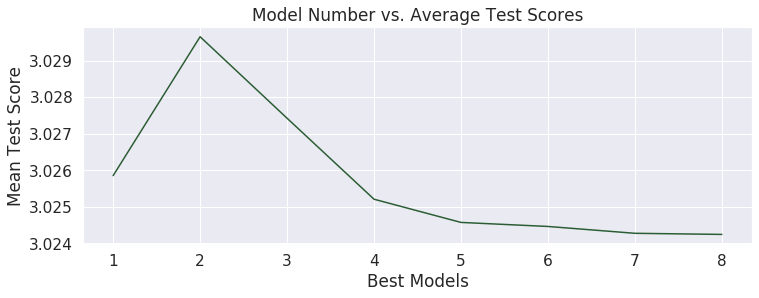

In [176]:
# plot average train and test scores

sns.lineplot(x=mean_scores_df.index, 
             y=mean_scores_df['mean_test_score'], color=mp.colors(4))

plt.xlabel('Best Models')
plt.ylabel('Mean Test Score')

plt.title('Model Number vs. Average Test Scores');

While overfitting increased slightly at model 5, the error kept geting reduced.

In [177]:
# evaluate final model with optimal parameters on test data
test_score = np.round(
    mean_squared_error(y_test, best_model_8.predict(X_test), squared=False), 5)
f'Holdout Evaluation Score: {test_score}'

'Holdout Evaluation Score: 2.99646'

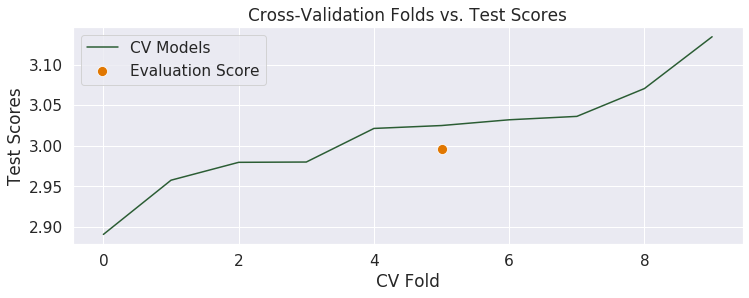

In [178]:
# plot cross-validation test scores and evaluation score
sns.lineplot(x=np.arange(10), y=np.sort(results), label='CV Models', color=mp.colors(4))
sns.scatterplot(x=[5], y=[test_score], s=100, label='Evaluation Score', color=mp.colors(5))

plt.xlabel('CV Fold')
plt.ylabel('Test Scores')
plt.legend()

plt.title('Cross-Validation Folds vs. Test Scores');

The final model falls in the middle of the cross-validation models.

The model is both accurate and generalizable.